# Capstone: Build an End-to-End Tabular Data ML Project Using SageMaker Studio and the Amazon SageMaker Python SDK

## Environment setup

This basic setup code has been included to help you get started. Read and run these cells first to get packages installed and variables created.

In [1]:
%%capture
%pip install -U shap
%pip install -U smdebug
%pip install imbalanced-learn
%pip install pytest-cov
%pip install pytest-filter-subpackage
%pip install sagemaker
%pip install -U seaborn

In [14]:
%pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.2/317.2 MB 79.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.5-py2.py3-none-any.whl size=317747923 sha256=4525d3be626996c2e5d5171ec92580cadade8391c5524e114d33e203f4f97a84
  Stored in directory: /home/sagemaker-user/.cache/pip/wheels/8f/cb/c0/cc57eb1bf0f9dc87cdaf2b0dbac49e58a210ff68d21d6fc709
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.9
    Uninstalling py4j-0.10.9.9:
      Successfully uninstalled py4j-0.10.9.9
Note: you may need to restart the kernel to use updated packages.


In [15]:
#required-libraries

import boto3
import datetime as datetime
import io
import IPython
import json
import math
import matplotlib.pyplot as plt  # visualization
import numpy as np
import pandas as pd
import pathlib
import re
import sagemaker
import seaborn as sns  # visualization
import statistics
import string
import sys
import time
import zipfile

from imblearn.over_sampling import SMOTE

from sagemaker import clarify
from sagemaker import get_execution_role
from sagemaker.analytics import ExperimentAnalytics
from sagemaker.dataset_definition.inputs import AthenaDatasetDefinition, DatasetDefinition, RedshiftDatasetDefinition
from sagemaker.debugger import CollectionConfig, DebuggerHookConfig, FrameworkProfile, ProfilerConfig, ProfilerRule, Rule, rule_configs
from sagemaker.estimator import Estimator
from sagemaker.experiments.run import Run, load_run
from sagemaker.feature_store.feature_definition import FeatureDefinition
from sagemaker.feature_store.feature_definition import FeatureTypeEnum
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.inputs import CreateModelInput
from sagemaker.inputs import TrainingInput
from sagemaker.inputs import TransformInput
from sagemaker.model import Model
from sagemaker.model_metrics import MetricsSource, ModelMetrics
from sagemaker.network import NetworkConfig
from sagemaker.processing import FeatureStoreOutput
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput, ScriptProcessor
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.s3 import S3Uploader
from sagemaker.session import Session
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.transformer import Transformer
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.workflow.condition_step import ConditionStep, JsonGet
from sagemaker.workflow.conditions import ConditionGreaterThan
from sagemaker.workflow.parameters import ParameterInteger, ParameterFloat, ParameterString
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.workflow.steps import CreateModelStep
from sagemaker.workflow.steps import ProcessingStep, TrainingStep
from sagemaker.workflow.steps import TransformStep
from sagemaker.workflow.steps import TuningStep
from sagemaker.xgboost.estimator import XGBoost
from sklearn.model_selection import train_test_split

In [3]:
#basic-variable-code-and-settings

%matplotlib inline
base_job_name = "capstone-smdebugger-job"
bucket = sagemaker.Session().default_bucket()
bucket_path = "s3://{}".format(bucket)
prefix = "sagemaker/capstone"
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
s3_client = boto3.client("s3") 
sagemaker_session = sagemaker.Session() 
save_interval = 5
sns.set(color_codes=True)

[05/02/25 15:29:58] INFO     Created S3 bucket: sagemaker-us-west-2-169137271401                     ]8;id=92243;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=771206;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#723\723]8;;\

## Dataset description

Five tables are stored in an Amazon Simple Storage Service (Amazon S3) bucket:
- **claims.csv**: A table with raw claims data.
- **customers.csv**: A table with raw customer data.
- **claims_preprocessed.csv**: A table with processed claims data.
- **customers_preprocessed.csv**: A table with processed customer data.
- **claims_customer.csv**: A table joined on the **policy_id** of the processed claims and customer data.

For this lab, start with the **claims.csv** and **customers.csv** tables. You process them in **Challenge 1** using Amazon SageMaker Data Wrangler. If you get stuck, or want a reference of what the processed dataset should be, you can review the pre-processed tables.

For this dataset, the target is **fraud**, a column in the claims table.

The claims table includes the following fields: 

- **policy_id**: The unique ID for the policy.
- **driver_relationship**: A list of relationships (Spouse, Self, Child, Other, N/A).
- **incident_type**: The incident type reported (Break-In, Collision, Theft).
- **collision_type**: The location of the collision (Front, Rear, Side, N/A).
- **incident_severity**: The severity of the incident (Minor, Major, Totaled).
- **authorities_contacted**: The type of authorities first contacted (None, Police, Ambulance, Fire).
- **num_vehicles_involved**: The number of vehicles involved in the incident (a range from 1 to 6).
- **num_injuries**: The number of injuries involved in the incident (a range from 1 to 4).
- **num_witnesses**: The number of witnesses to the incident (a range from 1 to 5).
- **police_report_available**: Whether or not a police report is available (yes or no).
- **injury_claim**: The value claimed for injuries in US dollars (300 to 576,300 USD).
- **vehicle_claim**: The value claimed for vehicle damage in US dollars (1000 to 51,051 USD).
- **total_claim_amount**: The total value claimed for injuries and damages (2100 to 588,868 USD).
- **incident_month**: The month of the incident (a range from 1 to 12).
- **incident_day**: The day of the incident (a range from 1 to 31).
- **incident_dow**: The day of the week of the incident (a range from 0 to 6 representing Sunday to Saturday).
- **incident_hour**: The hour of the incident (a range from 0 to 23)
- **fraud**: Whether or not the policy was fraudulent (0 or 1).

The customers table includes the following fields:

- **policy_id**: The unique ID for the policy.
- **customer_age**: The age of the customer (a range from 18 to 70).
- **months_as_customer**: The number of months for which this customer has paid insurance (a range from 1 to 495).
- **num_claims_past_year**: The number of claims made by the customer in the past year.
- **num_insurers_past_5_years**: The number of insurers that the customer had in the past 5 years.
- **policy_state**: The state that the customer lives in (AZ, CA, ID, NV, OR, WA).
- **policy_deductable**: The deductable value of the policy in US dollars (a range from 750 to 1100 USD).
- **policy_annual_premium**: The annual premium of the policy in US dollars (a range from 2200 to 3000 USD).
- **policy_liability**: The liability maximums for bodily injury, split into single and all bodily injuries (15/30, 25/50, 60/90, 100/200).
- **customer_zip**: The zip code of the customer (a range from 83201 to 99362).
- **customer_gender**: The gender of the customer (Male, Female, Other, Unknown).
- **customer_education**: The education level of the customer (Below High School, High School, Associate, Bachelor, Advanced Degree).
- **auto_year**: The year in which the automobile was made (a range from 2001 to 2020).

You can join these tables with an inner join on the **policy_id** column.

## Challenge lab navigation

This lab is set up with links that navigate between the challenge tasks and the appendix at the end of the notebook. If you want to review an item in the appendix, choose the associated hyperlink. When you want to return to the challenge that you are currently working on, choose the corresponding task hyperlink in the appendix.

The lab is organized as follows:

- Challenge 1: Analyze and prepare the dataset with SageMaker Data Wrangler
- Challenge 2: Create feature groups in SageMaker Feature Store
- Challenge 3: Train the model
- Challenge 4: Evaluate the model for bias
- Challenge 5: Batch transform
- Challenge 6: Build an automated pipeline
- Appendix

## Challenge 1: Analyze and prepare the dataset with SageMaker Data Wrangler

AnyCompany Consulting has received a request to analyze auto insurance fraud datasets and build a model to help predict if new claims are likely to be fraudulent or not. It has 5,000 customer records where it has labeled each claim as fraudulent or not. You can use this data to train, test, and validate your model before running inference on a new batch collection of records.

Use analysis features of Amazon SageMaker Data Wrangler to visualize the distributions of data in important columns, check for correlation between columns, and check for target leakage. Next, build a quick baseline model. Then, use data processing features of SageMaker Data Wrangler to transform columns so that they are better suited for training a more performant model. 

To complete this task, you complete the following subtasks:

- Review your data.
- Complete an exploratory data analysis in Amazon SageMaker Studio.
- Use an Amazon SageMaker Clarify processor job to run a bias report.
- Prepare your data.

This challenge takes approximately *100* minutes to complete.

### Task 1.1: Review your data

<a id="task1-1-continue"></a>

Access the tabular auto insurance dataset stored in your repository and review a sample of the dataset. The repository contains two unprocessed tables. One for customer data named **customers.csv** and one for claims data named **claims.csv**.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> The unprocessed tables are located in the **./data/** folder.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> The **claims.csv** and **customers.csv** tables are the unprocessed tables.

Take a moment to explore the tables. Are there any fields that stand out? Are there any fields that require careful preprocessing?

For detailed steps how to review your data, refer to <a href="#task1-1" target="_self">**Review your data (Task 1.1)**</a> in the *Appendix* section.

After you access the auto insurance fraud table and review a sample of the dataset, you have completed this task.

In [12]:
#add_your_task_1_1_code_here
claims = pd.read_csv('data/claims.csv')

customers = pd.read_csv('data/customers.csv')
claims.head(3)



,policy_id,driver_relationship,incident_type,collision_type,incident_severity,authorities_contacted,num_vehicles_involved,num_injuries,num_witnesses,police_report_available,injury_claim,vehicle_claim,total_claim_amount,incident_month,incident_day,incident_dow,incident_hour,fraud
0,1,Spouse,Collision,Front,Minor,NaN,2,0,0,No,71600,8913.668763,80513.668763,3,17,6,8,0
1,2,Self,Collision,Rear,Totaled,Police,3,4,0,Yes,6400,19746.724395,26146.724395,12,11,2,11,0
2,3,Self,Collision,Front,Minor,Police,2,0,1,Yes,10400,11652.969918,22052.969918,12,24,1,14,0


### Task 1.2: Complete an exploratory data analysis in SageMaker Studio 

<a id="task1-2-continue"></a>

Complete an exploratory data analysis by reviewing the data, identifying potential issues in the dataset, and checking for strong correlations between any columns and the target. You can explore the data in SageMaker Data Wrangler and in the notebook.

Specifically, spend time reviewing the following items:
- **Column histograms**: Review the columns in a visual format and check what kinds of values are in the dataset.
- **Quick model**: Review the dataset and think about an expected model outcome.
- **Feature correlation**: Check if there is strong correlation between any columns and the target.
- **Target leakage**: Check if there is any data that is dependent on the target value.

Access SageMaker Data Wrangler using SageMaker Canvas. To follow these directions, use one of the following options:
- **Option 1:** Open a new browser window for SageMaker Data Wrangler. Arrange the new window and the window displaying JupyterLab side-by-side. You can now have the directions visible as you explore the feature group.
- **Option 2:** Open a new browser tab in the existing browser window for SageMaker Data Wrangler. Switch between the browser tabs to follow these instructions.

If you get a **"The following instance type is not available: ml.m5.4xlarge. Try selecting a different instance below."** error when creating a new flow file, you can choose another instance type. Try the **ml.m5.8xlarge** next.

If the message **An error occurred loading this view** displays, close the **untitled.flow** tab and reopen the flow file from the file browser.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> There are many ways to explore the dataset. Open a SageMaker Data Wrangler flow to get started. You need both the **claims.csv** and **customers.csv** imported into SageMaker Data Wrangler from the S3 bucket that contains **databucket-** in its name.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> To import a second table, return to your **Data flow**, then choose the **Add data** tab to import another dataset.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> **Get data insights** is a way to explore data in SageMaker Data Wrangler. After you review some sample charts from your data, you can use other plotting tools in the notebook to analyze the data if you want to. The **plt** and **sns** libraries have been installed. Feel free to use any analysis tools that you are familiar with to explore the dataset.  

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Try joining the two tables using a **Join** on **policy_id**. Then, run another insights report. You can use an **Inner** join for these tables.

Did you get more meaningful results with a joined dataset?

For detailed steps to explore a dataset in SageMaker Canvas, refer to <a href="#task1-2-1" target="_self">**Explore a dataset in SageMaker Studio (Task 1.2)**</a> in the *Appendix* section.

For detailed steps to explore a dataset in the notebook, refer to <a href="#task1-2-2" target="_self">**Explore a dataset in the notebook (Task 1.2)**</a> in the *Appendix* section.

After you have processed the data using SageMaker Data Wrangler, explored the dataset and identified the processing steps that you want to conduct, you have completed this task.

In [ ]:
#add_your_task_1_2_code_here



### Task 1.3: Use a SageMaker Clarify processor job to run a bias report

<a id="task1-3-continue"></a>

Use SageMaker Clarify to run a pre-training bias report to catch class imbalance in the data. Use a SageMaker Data Wrangler flow to run the bias report in SageMaker Studio.
1. Start with joining the two tables.

- Join: **Inner** join for **claims.csv** to **customers.csv** on **policy_id**.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> To create a pre-training bias report, add a new analysis to your SageMaker Data Wrangler flow and choose **Bias Report** for the **Analysis type**.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> You can run the bias report several times, choosing different features to analyze each time.

For detailed steps how to join tables with SageMaker Data Wrangler, refer to <a href="#task1-3-1" target="_self">**Joining tables in SageMaker Studio (Task 1.3)**</a> in the *Appendix* section.

For detailed steps how to run a pre-training bias report, refer to <a href="#task1-3-2" target="_self">**Run a pre-training bias report (Task 1.3)**</a> in the *Appendix* section.

After you have run the pre-training bias report and viewed the report, you have completed this task.

### Task 1.4: Prepare your data

<a id="task1-4-continue"></a>

Prepare your dataset using SageMaker Data Wrangler. Focus on the following transformations, but feel free to include other transformations:

- Encode categorical (One-hot encoding): **authorities_contacted**, **collision_type**, **customer_gender**, **driver_relationship**, **incident_type**, and **policy_state**.
- Ordinal encode: **customer_education**, **policy_liability**, **incident_severity**, and **police_report_available**.
- Parse column as type: **vehicle_claim** and **total_claim_amount** from **Float** to **Long**.
- Manage columns (Drop column): **customer_zip**.
- Manage columns (Move column): **fraud** (using **Move to start**).
- Manage columns (Rename column): Remove the **/** symbol from **collision_type_N/A**, and **driver_relationship_N/A** with a **_**.
- Manage columns (Rename column): Rename **policy_id_0** to **policy_id**.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Join the **claims** table to the **customers** tables using a join in SageMaker Data Wrangler. 

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Join the two tables on the **policy_id** column.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Add transformations using the **Add transform** option.

Which transformations do you think affects the model training the most?

For detailed steps how to prepare data using SageMaker Data Wrangler, refer to <a href="#task1-4-1" target="_self">**Prepare data using SageMaker Data Wrangler (Task 1.4)**</a> in the *Appendix* section.

If you want to import an example set of processed data, refer to <a href="#task1-4-2" target="_self">**Import an example set of processed data (Task 1.4)**</a> in the *Appendix* section. 


## Challenge 2: Create feature groups in SageMaker Feature Store

Now that you have processed the dataset, create features and feature groups to be used in future analysis. Use SageMaker Feature Store to store these in a feature group and query them when training your model.

To complete this task, complete all of the following subtasks:

1. Export features to SageMaker Feature Store.
2. Query the feature group in an offline store with Amazon Athena.

This challenge takes approximately *30* minutes to complete.

### Task 2.1: Export features to SageMaker Feature Store

<a id="task2-1-continue"></a>

Use the SageMaker Data Wrangler **Export to** feature to create a custom Jupyter Notebook. The notebook creates a feature definition and a feature group. The notebook ingests the records into the feature group. In the notebook, complete the following steps:

- Set the values for record and event_time.
- Update the **container_uri** variable value:

    <i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> If you are running the lab in the **us-east-1** region, replace the current value with: `663277389841.dkr.ecr.us-east-1.amazonaws.com/sagemaker-data-wrangler-container:2.x`

    <i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> If you are running the lab in the **us-west-2** region, replace the current value with: `174368400705.dkr.ecr.us-west-2.amazonaws.com/sagemaker-data-wrangler-container:2.x`

- Run the notebook cells to create the feature group.
- Run the notebook cells to confirm the created feature group.
- Run the notebook cells to ingest records into the feature group.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> You will complete the initial steps for this task in SageMaker Data Wrangler. Then, you will complete the rest of the steps using the exported notebook. You will upload the exported notebook to JupyterLab to update and run the generated code. When you have finished creating your feature group, you can return to this notebook to continue with Task 2.2.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Add a custom transformation to create the **event_time** column. 

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> The code to add the custom transformation is as follows:
    


In [16]:
import time
import datetime
import pandas as pd
from pyspark.sql.functions import lit
date_time = datetime.date.today()

df = df.withColumn("event_time", lit(time.mktime(date_time.timetuple())))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│   4 from pyspark.sql.functions import lit                                                        │
│   5 date_time = datetime.date.today()                                                            │
│   6                                                                                              │
│ ❱ 7 df = df.withColumn("event_time", lit(time.mktime(date_time.timetuple())))                    │
│   8                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'df' is not defined


<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> At the end of your SageMaker Data Wrangler flow, choose the **+** icon, choose the **Export via Jupyter Notebook** option, and choose **SageMaker Feature Store**.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> You can turn off the online store by changing the **enable_online_store** value from **True** to **False**.

How would you use SageMaker Feature Store to store and query your records for training, as opposed to inference?

For detailed steps how to create a feature group using the **Export to** option, refer to <a href="#task2-1" target="_self">**Create a feature group using the Export to option (Task 2.1)**</a> in the *Appendix* section. 

After you have created a feature group and ingested data into the feature group, you have completed this task.

### Task 2.2: Query the feature group in an offline store with Athena

<a id="task2-2-continue"></a>

Use Athena to extract records from an offline data store. You split these records into train, test, and validation sets in the next challenge.

Use the provided code cell below to make the Amazon Athena API calls. You could use the Amazon Athena console to make the query, but that is beyond the scope of this lab.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> You can create an Athena query with **feature_group.athena_query()** and get the table name with **query.table_name**.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> You can run a query with **query.run(query_string=query_string, output_location=output_location)** and read the returned value as a dataframe with **query.as_dataframe()**.

How could you use **event_time** to keep track of features that occur at different points in your dataset's timeline?

For detailed steps how to extract records from an offline data store with Athena, refer to <a href="#task2-2" target="_self">**Extract records from an offline store with Athena (Task 2.2)**</a> in the *Appendix* section.

After you have saved the returned Athena query as a dataframe variable, you have completed this task.

In [ ]:
#add_your_task_2_2_code_here



## Challenge 3: Train the model

Your model is ready to train. Split the data into train, test, and validation datasets, and train the model. 

SageMaker Autopilot was run on this data earlier and got a **F1** of **0.616**, an **accuracy** of **0.978**, an **AUC** of **0.918**, and a **Recall** of **0.539**. To learn more about the metrics that SageMaker Autopilot produces, refer to the *autopilot-metrics-validation* document in the *Additional resources* section for more information.

While you are training and tuning, work on reaching or exceeding the SageMaker Autopilot scores and confirm that Amazon SageMaker Debugger is reporting no errors.

To complete this task, you complete the following subtasks:

- Create an experiment and a run.
- Split the data into train, test, and validation datasets.
- Configure and run a training job.
    - Run a basic training job.
    - Run a training job with SageMaker Debugger enabled and analyze the reports (optional).
- Perform hyperparameter tuning.

This challenge takes approximately *110* minutes to complete.


### Task 3.1: Name an experiment and a run

<a id="task3-1-continue"></a>

Set up variables to name both the experiment and the runs. 
An experiment requires an **experiment_name**, **run_name** and a **description**. 

For detailed steps how to create the variables, refer to <a href="#task3-1" target="_self">**Name an experiment and a run (Task 3.1)**</a> in the *Appendix* section.


In [19]:
from time import gmtime, strftime
#add_your_task_3_1_code_here
create_date = strftime("%m%d%H%M")

experiment_name = "capstone".format(create_date)
description = "Using SageMaker Experiments - Capstone."

# create initial run_name
run_name = "capstone-run-{}".format(create_date)

# define a run_tag
run_tags = [{'Key': 'capstone', 'Value': 'capstone-run'}]

print(f"Experiment name - {experiment_name},  run name - {run_name}")


Experiment name - capstone,  run name - capstone-run-05021637


### Task 3.2: Split the data into train, test, and validation datasets

<a id="task3-2-continue"></a>

Use the features that you queried from SageMaker Feature Store and split the data into train, test, and validation datasets.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Use **np.split** to split the dataset into three partitions.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Use the **to_csv** to create CSV files and use **S3Uploader.upload** to add the files to Amazon S3.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> The final product of your split should be a **data_inputs** variable with values for **train** and **validation**.

For detailed steps how to split data into train, test, and validation datasets, refer to <a href="#task3-2" target="_self">**Split data into train, test, and validation datasets (Task 3.2)**</a> in the *Appendix* section. 

After you have split the data into train, test, and validation datasets, you have completed this task.

In [20]:
#add_your_task_3_2_code_here
#import-dataset
lab_test_data = pd.read_csv('data/claims_customer.csv')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)
lab_test_data.head()


,fraud,policy_id,incident_type_theft,policy_state_ca,policy_deductable,num_witnesses,policy_state_or,incident_month,customer_gender_female,num_insurers_past_5_years,customer_gender_male,total_claim_amount,authorities_contacted_police,incident_day,collision_type_side,customer_age,customer_education,driver_relationship_child,driver_relationship_spouse,injury_claim,incident_dow,collision_type_na,incident_severity,driver_relationship_self,num_claims_past_year,months_as_customer,auto_year,num_vehicles_involved,policy_state_nv,authorities_contacted_ambulance,num_injuries,policy_liability,police_report_available,driver_relationship_na,incident_type_breakin,authorities_contacted_none,authorities_contacted_fire,driver_relationship_other,policy_state_id,incident_hour,vehicle_claim,incident_type_collision,policy_annual_premium,policy_state_az,policy_state_wa,collision_type_rear,collision_type_front
0,0,1675,0,0,750,0,0,2,0,1,0,12000,1,14,0,61,4,0,0,0,3,1,0,0,0,135,2020,1,0,0,0,1,0,1,1,0,0,0,0,20,12000,0,3000,1,0,0,0
1,0,9,0,0,750,0,0,9,0,1,1,18500,0,21,1,55,4,0,1,0,5,0,0,0,0,201,2019,2,1,0,0,1,0,0,0,1,0,0,0,15,18500,1,3000,0,0,0,0
2,0,1687,0,1,750,0,0,7,1,1,0,17500,1,18,1,42,1,1,0,0,3,0,1,0,0,80,2014,2,0,0,0,1,0,0,0,0,0,0,0,16,17500,1,3000,0,0,0,0
3,0,1687,0,1,750,0,0,7,0,1,1,17500,1,18,1,54,1,1,0,0,3,0,1,0,0,72,2017,2,0,0,0,1,0,0,0,0,0,0,0,16,17500,1,3000,0,0,0,0
4,0,1692,0,0,750,2,0,6,1,1,0,26000,1,5,0,63,3,0,0,4500,2,0,2,1,0,80,2020,5,0,0,4,2,1,0,0,0,0,0,0,8,21500,1,2800,1,0,0,1


In [21]:
#split-dataset
train_data, validation_data, test_data = np.split(
    lab_test_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(lab_test_data)), int(0.9 * len(lab_test_data))],
)

train_data.to_csv('train_data.csv', index=False, header=False)
validation_data.to_csv('validation_data.csv', index=False, header=False)

/opt/conda/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [22]:
#upload-dataset
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

sagemaker_session = sagemaker.Session()

train_path = S3Uploader.upload('train_data.csv', 's3://{}/{}'.format(bucket, prefix))
validation_path = S3Uploader.upload('validation_data.csv', 's3://{}/{}'.format(bucket, prefix))

train_input = TrainingInput(train_path, content_type='text/csv')
validation_input = TrainingInput(validation_path, content_type='text/csv')

data_inputs = {
    'train': train_input,
    'validation': validation_input
}

### Task 3.3: Configure and run a training job

<a id="task3-3-continue"></a>

Start your first training job, setting up the container, an estimator, and the hyperparameters. Then, train the model with **fit()**. If you want to examine more detailed reports, enable SageMaker Debugger with **DebuggerHookConfig**.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Use the **XGBoost** container with version **1.5-1**.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> To get started, set the hyperparameters for **eta**, **gamma**, **max_depth**, **min_child_weight**, **num_round**, **objective**, and **subsample**.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Use the **data_inputs** that you created earlier in Challenge 1 as the **inputs** value for your training job.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> You can configure a training job by setting the inputs and experiment_config. The experiment_config should contain a **sagemaker_session**, a **run_name**, and a **experiment_name**.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> If you want to use SageMaker Debugger, configure the **DebuggerHookConfig**, the **ProfilerConfig**, and the Debugger **rule** object.

Which hyperparameters are most likely to have a large impact on your model's performance and accuracy? Which hyperparameters do you plan on tuning first?

For detailed steps how to configure and run a basic training job, refer to <a href="#task3-3-1" target="_self">**Configure and run a basic training job (Task 3.3)**</a> in the *Appendix* section.

For detailed steps how to configure and run a training job with Debugger enabled and analyze reports, refer to <a href="#task3-3-2" target="_self">**Configure and run a training job with SageMaker Debugger enabled and analyze reports (Task 3.3)**</a> in the *Appendix* section.

After you have finished one or more training jobs, you have completed this task.

In [26]:
#add_your_task_3_3_code_here
from sagemaker import image_uris
container = image_uris.retrieve(framework='xgboost',region=boto3.Session().region_name,version='1.5-1')

# initialize hyperparameters
eta=0.2
gamma=4
max_depth=5
min_child_weight=6
num_round=800
objective='binary:logistic'
subsample=0.8
verbosity=0

hyperparameters = {
        "max_depth":max_depth,
        "eta":eta,
        "gamma":gamma,
        "min_child_weight":min_child_weight,
        "subsample":subsample,
        "verbosity":verbosity,
        "objective":objective,
        "num_round":num_round
}

# Set up the estimator
xgb = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.m5.xlarge',
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session=sagemaker_session,
    EnableSageMakerMetricsTimeSeries=True,
    hyperparameters=hyperparameters,
    tags = run_tags
)


#Run the training job link to Experiment.
with Run(
    experiment_name=experiment_name,
    run_name=run_name,
    tags=run_tags,
    sagemaker_session=sagemaker_session,
) as run:

    run.log_parameters({
                        "eta": eta, 
                        "gamma": gamma, 
                        "max_depth": max_depth,
                        "min_child_weight": min_child_weight,
                        "num_round": num_round,
                        "objective": objective,
                        "subsample": subsample,
                        "verbosity": verbosity
                       })
    
#    you may also specify metrics to log
#    run.log_metric(name="", value=x)

# Train the model associating the training run with the current "experiment"
    xgb.fit(
        inputs = data_inputs
    ) 


[05/02/25 16:54:44] INFO     Ignoring unnecessary instance type: None.                            ]8;id=473377;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=404069;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

[05/02/25 16:54:45] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=101741;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=611158;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=904449;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=467065;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-05-02-16-54-45-412                                             

2025-05-02 16:54:46 Starting - Starting the training job...
2025-05-02 16:55:20 Downloading - Downloading input data...
2025-05-02 16:55:45 Downloading - Downloading the training image......
2025-05-02 16:56:31 Training - Training image download completed. Training in progress./miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-05-02 16:56:42.038 ip-10-0-105-194.us-west-2.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-05-02 16:56:42.059 ip-10-0-105-194.us-west-2.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-05-02:16:56:42:INFO] Imported framework sagemaker_xgboost_container.training
[2025-05-02:16:56:42:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value its

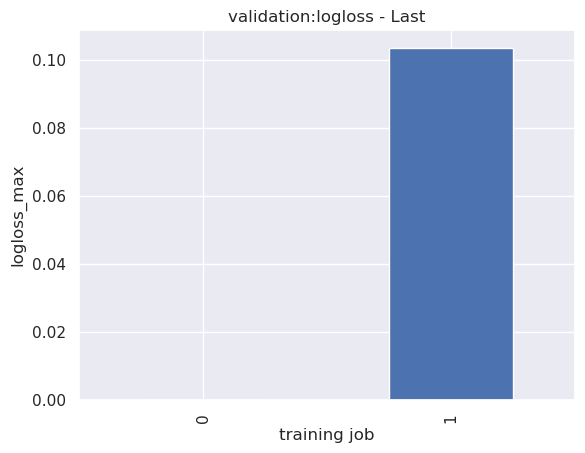

In [32]:
#visualize-training-results-table
run_component_analytics = ExperimentAnalytics(
    experiment_name=experiment_name,
    sagemaker_session=sagemaker_session
)
run_component_analytics.dataframe()["validation:logloss - Last"].plot(kind="bar", title="validation:logloss - Last", xlabel="training job", ylabel="logloss_max")
plt.show()

Index(['TrialComponentName', 'DisplayName', 'eta', 'gamma', 'max_depth',
       'min_child_weight', 'num_round', 'objective', 'subsample', 'verbosity',
       'Trials', 'Experiments', 'SourceArn', 'SageMaker.ImageUri',
       'SageMaker.InstanceCount', 'SageMaker.InstanceType',
       'SageMaker.VolumeSizeInGB', 'validation:logloss - Min',
       'validation:logloss - Max', 'validation:logloss - Avg',
       'validation:logloss - StdDev', 'validation:logloss - Last',
       'validation:logloss - Count', 'train:logloss - Min',
       'train:logloss - Max', 'train:logloss - Avg', 'train:logloss - StdDev',
       'train:logloss - Last', 'train:logloss - Count', 'train - MediaType',
       'train - Value', 'validation - MediaType', 'validation - Value',
       'SageMaker.DebugHookOutput - MediaType',
       'SageMaker.DebugHookOutput - Value',
       'SageMaker.ModelArtifact - MediaType',
       'SageMaker.ModelArtifact - Value'],
      dtype='object')


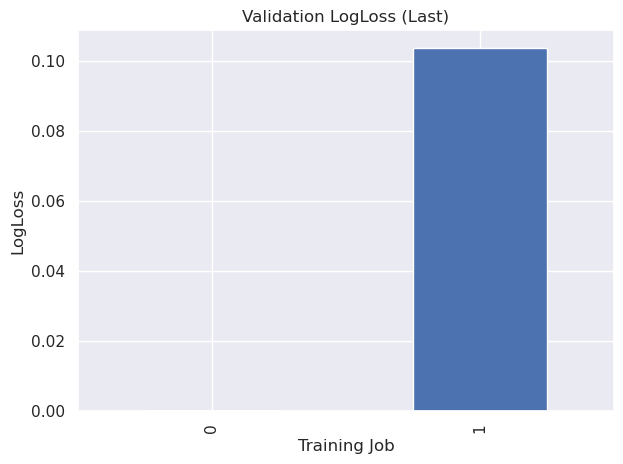

In [33]:

df = run_component_analytics.dataframe()

# Check available columns
print(df.columns)

# Plot if the column exists
if "validation:logloss - Last" in df.columns:
    df["validation:logloss - Last"].plot(
        kind="bar",
        title="Validation LogLoss (Last)",
        xlabel="Training Job",
        ylabel="LogLoss"
    )
    plt.tight_layout()
    plt.show()
else:
    print("Column 'validation:logloss - Last' not found in experiment analytics.")

### Task 3.4: Hyperparameter tuning

<a id="task3-4-continue"></a>

Now that you have finished a training job and analyzed it, tune hyperparameter ranges based on your findings and run more training jobs to improve the model.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> To get started, set the hyperparameter ranges for **alpha**, **eta**, **max_depth**, **min_child_weight**, and **num_round**.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> When you run **HyperparameterTuner**, make sure to set the **objective_metric_name** and **objective_type** based on your findings.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> To check if you have improved over the SageMaker Autopilot results, open the **Experiments and runs** menu in **SageMaker resources**. In your run, view the **Metrics**. The **ObjectiveMetric** should be higher than the **F1** score of **0.616** and the **validation:auc** should have a **Final value** higher than the SageMaker Autopilot score of **0.918**.

When you tuned your hyperparameters, which one caused the greatest improvement in model performance?

For detailed steps how to configure training hyperparameter ranges, refer to <a href="#task3-4" target="_self">**Configure training hyperparameter ranges (Task 3.4)**</a> in the *Appendix* section.

After you have configured the training hyperparameter ranges and started more training jobs, you have completed this task.

In [34]:
#add_your_task_3_4_code_here
#tune-model
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

# Setup the hyperparameter ranges
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 2),
    'eta': ContinuousParameter(0, 1),
    'max_depth': IntegerParameter(1, 10),
    'min_child_weight': ContinuousParameter(1, 10),
    'num_round': IntegerParameter(100, 1000)
}
# Define the target metric and the objective type (max/min)
objective_metric_name = 'validation:auc'
objective_type='Maximize'
# Define the HyperparameterTuner
tuner = HyperparameterTuner(
    estimator = xgb,
    objective_metric_name = objective_metric_name,
    hyperparameter_ranges = hyperparameter_ranges,
    objective_type = objective_type,
    max_jobs=12,
    max_parallel_jobs=4,
    early_stopping_type='Auto',
)

with load_run(sagemaker_session=sagemaker_session, experiment_name=experiment_name, run_name=run_name) as run:
# Tune the model
    tuner.fit(
        inputs = data_inputs,
        job_name = experiment_name,
    )
    


[05/02/25 17:04:43] WARNING  run_name is explicitly supplied in load_run, which will be prioritized to   ]8;id=307092;file:///opt/conda/lib/python3.12/site-packages/sagemaker/experiments/run.py\run.py]8;;\:]8;id=617435;file:///opt/conda/lib/python3.12/site-packages/sagemaker/experiments/run.py#866\866]8;;\
                             load the Run object. In other words, the run name in the experiment config,           
                             fetched from the job environment or the current run context, will be                  
                             ignored.                                                                              

[05/02/25 17:04:44] INFO     The run (capstone-run-05021637) under experiment (capstone) already exists. ]8;id=794266;file:///opt/conda/lib/python3.12/site-packages/sagemaker/experiments/run.py\run.py]8;;\:]8;id=206678;file:///opt/conda/lib/python3.12/site-packages/sagemaker/experiments/run.py#206\206]8;;\
                             Loading it.                                                                           

                    INFO     Creating hyperparameter tuning job with name: capstone                 ]8;id=635046;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=136571;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#3383\3383]8;;\

.......................................................!


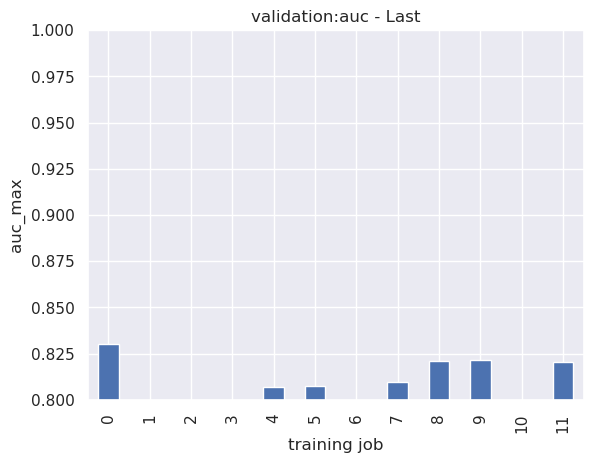

In [35]:
#get_experiment_analytics 
run_component_analytics = ExperimentAnalytics(
    experiment_name=experiment_name+"-aws-tuning-job",
    sagemaker_session=sagemaker_session
)

run_component_analytics.dataframe()

#visualize-tuning-results-auc-max
if run_component_analytics.dataframe()["validation:auc - Max"].iloc[1] != 0:
    run_component_analytics.dataframe()["validation:auc - Max"].plot(kind="bar", title="validation:auc - Max", xlabel="training job", ylabel="auc_max").set_ylim([0.8, 1]);
else:
    run_component_analytics.dataframe()["validation:auc - Last"].plot(kind="bar", title="validation:auc - Last", xlabel="training job", ylabel="auc_max").set_ylim([0.8, 1]);
    
plt.show()

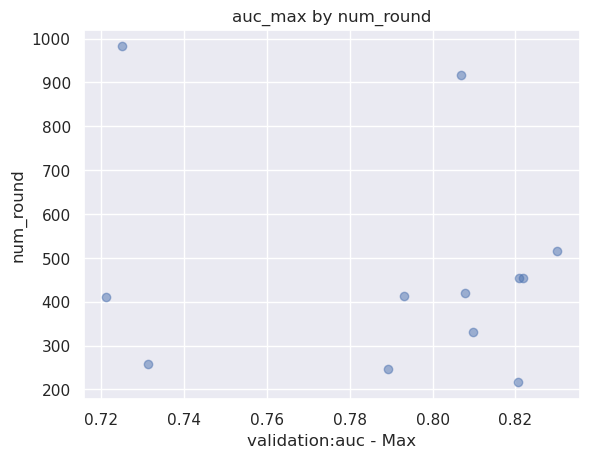

In [36]:
#visualize-tuning-results-auc-max-scatter
N = 12
if run_component_analytics.dataframe()["validation:auc - Max"].iloc[1] != 0:
    x = run_component_analytics.dataframe().sort_values(by=['TrialComponentName'])["validation:auc - Max"];
else:
    x = run_component_analytics.dataframe().sort_values(by=['TrialComponentName'])["validation:auc - Last"];
y = run_component_analytics.dataframe().sort_values(by=['TrialComponentName'])["num_round"]

plt.scatter(x, y, alpha=0.5)
plt.title("auc_max by num_round")
plt.xlabel("validation:auc - Max")
plt.ylabel("num_round");
plt.show()

In [37]:
#print-best
tuner.best_training_job()

'capstone-011-7f61d38e'

## Challenge 4: Evaluate the model for bias

Now that your model is trained, evaluate your model using Amazon SageMaker Clarify. If you find any issues, you can remove the imbalance detected and retrain the model.

To complete this task, you complete the following subtasks:

- Create a model from the training job.
- Create a SageMaker Clarify model configuration.
- Create a SageMaker Clarify bias configuration.
- Use a SageMaker Clarify processor job to run the bias, data, and model reports.
- Remove the imbalance detected with SageMaker Clarify (optional).
- Retrain the model (optional).

This challenge takes approximately *80* minutes to complete.

### Task 4.1: Create a model from the training job

<a id="task4-1-continue"></a>

Create an XGBoost model, calling **create_model** with the **model_name**, **role**, and **container_def** that you define.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Call **xgb.create_model()** and pick a name for your model.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Use your session and call **create_model**, passing in the **model_name**, **role**, and **container_def**.

For detailed steps how to create a model, refer to <a href="#task4-1" target="_self">**Create a model (Task 4.1)**</a> in the *Appendix* section.

After you have created a model, you have completed this task.

In [48]:
#add_your_task_4_1_code_here
model_name = "capstone-clarify-model"
model = xgb.create_model(name=model_name)
container_def = model.prepare_container_def()
sagemaker_session.create_model(model_name, role, container_def)



[05/02/25 21:15:54] INFO     Creating model with name: capstone-clarify-model                       ]8;id=563101;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=970499;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4094\4094]8;;\

[05/02/25 21:15:55] WARNING  Using already existing model: capstone-clarify-model                   ]8;id=772861;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=830026;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4105\4105]8;;\

'capstone-clarify-model'

### Task 4.2: Create a SageMaker Clarify model configuration

<a id="task4-2-continue"></a>

Create a SageMaker Clarify model configuration using **SageMakerClarifyProcessor**.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Set the **instance_count** and the **instance_type**.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Use the **role** and **session** created at the beginning of the Capstone lab.

For detailed steps how to create a SageMaker Clarify model configuration, refer to <a href="#task4-2" target="_self">**Create a SageMaker Clarify model configuration (Task 4.2)**</a> in the *Appendix* section.

After you have created a SageMaker Clarify model configuration, you have completed this task.

In [49]:
#add_your_task_4_2_code_here
#enable-clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.m5.xlarge", 
    sagemaker_session=sagemaker_session
)



[05/02/25 21:15:57] INFO     Ignoring unnecessary instance type: None.                            ]8;id=481827;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=450152;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

### Task 4.3: Create a SageMaker Clarify bias configuration

<a id="task4-3-continue"></a>

Create a data configuration, a model configuration, a label configuration, and a bias configuration.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Start with a **DataConfig**, setting the input path, output path, headers, and dataset type.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Then, create a **ModelConfig**, choosing the content and accept type, the model name, the instance type, and the instance count.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Next, create a **ModelPredictedLabelConfig**, setting the probability threshold.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Finally, create a **BiasConfig**, setting the label values or threshold, the facet name, and the facet values or threshold.

Which facets do you want to explore first in your bias report? Are there any features that are particularly susceptible to bias?

For detailed steps how to create a SageMaker Clarify bias configuration, refer to <a href="#task4-3" target="_self">**Create a SageMaker Clarify bias configuration (Task 4.3)**</a> in the *Appendix* section.

After you have created a SageMaker Clarify bias configuration, you have completed this task.

In [50]:
#add_your_task_4_3_code_here

bias_report_output_path = "s3://{}/{}/clarify-bias".format(bucket, prefix)
bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_path,
    s3_output_path=bias_report_output_path,
    label="fraud",
    headers=train_data.columns.to_list(),
    dataset_type="text/csv",
)

#define-model-config

model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    accept_type="text/csv",
    content_type="text/csv",
)

#define-model-predicted-label-config

predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

#define-bias-config

bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], facet_name="customer_gender_female", facet_values_or_threshold=[0], group_name="customer_age"
)


### Task 4.4: Use a SageMaker Clarify processor job to run the bias, data, and model reports

<a id="task4-4-continue"></a>

You chose all your configurations already for the bias, data, and model reports. Now, run the reports.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Pass the **data_config**, **bias_config**, **model_predicted_label_config**, and **model_config** values to **run_bias**.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> You need to set the **pre_training_methods** and **post_training_methods**.

For detailed steps how to run bias, data, and model reports using SageMaker Clarify, refer to <a href="#task4-4" target="_self">**Run bias, data, and model reports using SageMaker Clarify (Task 4.4)**</a> in the *Appendix* section.

After you have used a SageMaker Clarify processor job to run the bias, data, and model reports, you have completed this task.

In [51]:
#add_your_task_4_4_code_here
#run-bias-report

clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods="all",
    post_training_methods="all",
)


[05/02/25 21:16:06] INFO     Analysis Config: {'dataset_type': 'text/csv', 'headers': ['fraud',     ]8;id=532737;file:///opt/conda/lib/python3.12/site-packages/sagemaker/clarify.py\clarify.py]8;;\:]8;id=75315;file:///opt/conda/lib/python3.12/site-packages/sagemaker/clarify.py#1987\1987]8;;\
                             'policy_id', 'incident_type_theft', 'policy_state_ca',                                
                             'policy_deductable', 'num_witnesses', 'policy_state_or',                              
                             'incident_month', 'customer_gender_female',                                           
                             'num_insurers_past_5_years', 'customer_gender_male',                                  
                             'total_claim_amount', 'authorities_contacted_police', 'incident_day',                 
                             'collision_type_side', 'customer_age', 'customer_education',                          
                             'driver_relationship_child', 'driver_relationship_spouse',                            
                             'injury_claim', 'incident_dow', 'collision_type_na',                                  
                             'incident_severity', 'driver_relationship_self',                                      
                             'num_claims_past_year', 'months_as_customer', 'auto_year',                            
                             'num_vehicles_involved', 'policy_state_nv',                                           
                             'authorities_contacted_ambulance', 'num_injuries', 'policy_liability',                
                             'police_report_available', 'driver_relationship_na',                                  
                             'incident_type_breakin', 'authorities_contacted_none',                                
                             'authorities_contacted_fire', 'driver_relationship_other',                            
                             'policy_state_id', 'incident_hour', 'vehicle_claim',                                  
                             'incident_type_collision', 'policy_annual_premium', 'policy_state_az',                
                             'policy_state_wa', 'collision_type_rear', 'collision_type_front'],                    
                             'label': 'fraud', 'label_values_or_threshold': [1], 'facet':                          
                             [{'name_or_index': 'customer_gender_female', 'value_or_threshold':                    
                             [0]}], 'group_variable': 'customer_age', 'methods': {'report':                        
                             {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias':                  
                             {'methods': 'all'}, 'post_training_bias': {'methods': 'all'}},                        
                             'predictor': {'model_name': 'capstone-clarify-model', 'instance_type':                
                             'ml.m5.xlarge', 'initial_instance_count': 1, 'accept_type':                           
                             'text/csv', 'content_type': 'text/csv'}, 'probability_threshold': 0.8}                

                    INFO     Creating processing-job with name Clarify-Bias-2025-05-02-21-16-06-748 ]8;id=195541;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=844293;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1575\1575]8;;\

..................sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
We are not in a supported iso region, /bin/sh exiting gracefully with no changes.
INFO:sagemaker-clarify-processing:Starting SageMaker Clarify Processing job
INFO:analyzer.data_loading.data_loader_util:Analysis config path: /opt/ml/processing/input/config/analysis_config.json
INFO:analyzer.data_loading.data_loader_util:Analysis result path: /opt/ml/processing/output
INFO:analyzer.data_loading.data_loader_util:This host is algo-1.
INFO:analyzer.data_loading.data_loader_util:This host is the leader.
INFO:analyzer.data_loading.data_loader_util:Number of hosts in the cluster is 1.
INFO:sagemaker-clarify-processing:Running Python / Pandas based analyzer.
INFO:analyzer.data_loading.data_loader_factory:Dataset type: text/csv uri: /opt/ml/processing/input/data
INFO:sagemaker-clarify

In [52]:
#configure-shap

testing_data, clarify_data = train_test_split(test_data, test_size =0.005)
clarify_data = clarify_data.drop(columns=["fraud"])
clarify_data.to_csv('clarify_data.csv', index=False, header=False)
clarify_path = S3Uploader.upload('clarify_data.csv', 's3://{}/{}'.format(bucket, prefix))

shap_config = clarify.SHAPConfig(
    baseline=clarify_path,
    num_samples=15,
    agg_method="mean_abs",
    save_local_shap_values=True,
)

explainability_output_path = "s3://{}/{}/clarify-explainability".format(bucket, prefix)
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=clarify_path,
    s3_output_path=explainability_output_path,
    headers=clarify_data.columns.to_list(),
    dataset_type="text/csv",
)

In [53]:
#run-explainability-report

clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
)

[05/02/25 21:29:05] INFO     Analysis Config: {'dataset_type': 'text/csv', 'headers': ['policy_id', ]8;id=8019;file:///opt/conda/lib/python3.12/site-packages/sagemaker/clarify.py\clarify.py]8;;\:]8;id=270192;file:///opt/conda/lib/python3.12/site-packages/sagemaker/clarify.py#1987\1987]8;;\
                             'incident_type_theft', 'policy_state_ca', 'policy_deductable',                        
                             'num_witnesses', 'policy_state_or', 'incident_month',                                 
                             'customer_gender_female', 'num_insurers_past_5_years',                                
                             'customer_gender_male', 'total_claim_amount',                                         
                             'authorities_contacted_police', 'incident_day', 'collision_type_side',                
                             'customer_age', 'customer_education', 'driver_relationship_child',                    
                             'driver_relationship_spouse', 'injury_claim', 'incident_dow',                         
                             'collision_type_na', 'incident_severity', 'driver_relationship_self',                 
                             'num_claims_past_year', 'months_as_customer', 'auto_year',                            
                             'num_vehicles_involved', 'policy_state_nv',                                           
                             'authorities_contacted_ambulance', 'num_injuries', 'policy_liability',                
                             'police_report_available', 'driver_relationship_na',                                  
                             'incident_type_breakin', 'authorities_contacted_none',                                
                             'authorities_contacted_fire', 'driver_relationship_other',                            
                             'policy_state_id', 'incident_hour', 'vehicle_claim',                                  
                             'incident_type_collision', 'policy_annual_premium', 'policy_state_az',                
                             'policy_state_wa', 'collision_type_rear', 'collision_type_front'],                    
                             'predictor': {'model_name': 'capstone-clarify-model', 'instance_type':                
                             'ml.m5.xlarge', 'initial_instance_count': 1, 'accept_type':                           
                             'text/csv', 'content_type': 'text/csv'}, 'methods': {'report':                        
                             {'name': 'report', 'title': 'Analysis Report'}, 'shap': {'use_logit':                 
                             False, 'save_local_shap_values': True, 'baseline':                                    
                             's3://sagemaker-us-west-2-169137271401/sagemaker/capstone/clarify_data                
                             .csv', 'num_samples': 15, 'agg_method': 'mean_abs'}}}                                 

                    INFO     Creating processing-job with name                                      ]8;id=667249;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=131311;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1575\1575]8;;\
                             Clarify-Explainability-2025-05-02-21-29-05-413                                        

..................sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
We are not in a supported iso region, /bin/sh exiting gracefully with no changes.
INFO:sagemaker-clarify-processing:Starting SageMaker Clarify Processing job
INFO:analyzer.data_loading.data_loader_util:Analysis config path: /opt/ml/processing/input/config/analysis_config.json
INFO:analyzer.data_loading.data_loader_util:Analysis result path: /opt/ml/processing/output
INFO:analyzer.data_loading.data_loader_util:This host is algo-1.
INFO:analyzer.data_loading.data_loader_util:This host is the leader.
INFO:analyzer.data_loading.data_loader_util:Number of hosts in the cluster is 1.
INFO:sagemaker-clarify-processing:Running Python / Pandas based analyzer.
INFO:analyzer.data_loading.data_loader_factory:Dataset type: text/csv uri: /opt/ml/processing/input/data
INFO:sagemaker-clarify

### Task 4.5: Remove the imbalance detected with SageMaker Clarify (optional)

<a id="task4-5-continue"></a>

There are many ways to remove the imbalance detected with SageMaker Clarify. Use any method that you are familiar with. In this lab, a Synthetic Minority Over-sampling Technique (SMOTE) example is provided that removes bias from one of the columns.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> After you are finished removing the imbalance and want to retest, create a new resampled dataframe. You create and upload a new CSV file in the next task.

For detailed steps how to remove imbalance, refer to <a href="#task4-5" target="_self">**Remove imbalance (Task 4.5)**</a> in the *Appendix* section.

After you have removed any imbalance detected with SageMaker Clarify, you have completed this task.

In [ ]:
#add_your_task_4_5_code_here



### Task 4.6: Retrain the model (optional)

<a id="task4-6-continue"></a>

Upload the new file to Amazon S3. Then, create a new estimator and retrain with the new data.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Use **s3_client.upload_file** to upload the new file to your bucket.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Use **xgboost_starter_script.py** and call **XGBoost**. Then, retrain with the new data.

Did the retrained model achieve a higher F1 score? If you used SageMaker Debugger, were you able to resolve all of the discovered issues?

For detailed steps how to retrain the model, refer to <a href="#task4-6" target="_self">**Retrain the model (Task 4.6)**</a> in the *Appendix* section.

After you have retrained the model, you have completed this task.

In [ ]:
#add_your_task_4_6_code_here



## Challenge 5: Batch transform

Your model is ready for deployment. Use a batch transform job with batch records and view the prediction and accuracy data in Amazon S3. Then, clean up some of your SageMaker instances.

To complete this task, you complete the following subtasks:

- Create a batch transform job for your model.
- View the prediction data in Amazon S3.
- Clean up SageMaker instances (optional).

This challenge takes approximately *40* minutes to complete.

### Task 5.1: Create a batch transform job for your model

<a id="task5-1-continue"></a>

Create a batch transform job using **transformer** on the model estimator. Then, run the batch job.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Use transformer and configure the **instance_count**, **instance_type**, **strategy**, **assemble_with**, and **output_path**.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Send your test data, which is listed in **test_path** to the endpoint and wait for the results.

For detailed steps how to create a batch transform job, refer to <a href="#task5-1" target="_self">**Create a batch transform job (Task 5.1)**</a> in the *Appendix* section.

After you have created a batch transform job and run it with a set of records, you have completed this task.

In [ ]:
#add_your_task_5_1_code_here



### Task 5.2: View the prediction data in Amazon S3

<a id="task5-2-continue"></a>

When your batch transform job is complete, read the data from Amazon S3. 

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> You can copy data from the transformer output using **%aws s3 cp --recursive $transformer.output_path ./**

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> When you have the data, you can view it with **%head test_data_batch.csv.out**

Take a look at the predictions. Are there any predictions that are surprising?

For detailed steps how to view prediction data from a batch transform job, refer to <a href="#task5-2" target="_self">**View prediction data from a batch transform job (Task 5.2)**</a> in the *Appendix* section.

After you have viewed the prediction data from the batch transform job, you have completed this task.

In [ ]:
#add_your_task_5_2_code_here



### Task 5.3: Clean up SageMaker instances (optional)

To keep costs low, best practice is to delete instances that you are not using anymore. You can quickly delete instances using SageMaker Studio. Take a moment now to open your current resources list in SageMaker Studio and close out any remaining instances.

If you plan to complete the next pipeline task, **leave the notebook instance running**.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> You can view a list of running instances by choosing the **Running Terminals and Kernels** icon in SageMaker Studio.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> You can use the **Shut down** icon to stop an instance.

<a id="task5-3-continue"></a>

For detailed steps how to clean up SageMaker instances in SageMaker Studio, refer to <a href="#task5-3" target="_self">**Clean up SageMaker instances in SageMaker Studio (Task 5.3)**</a> in the *Appendix* section.

After you have stopped all SageMaker instances in SageMaker Studio, you have completed this task.

## Challenge 6: Build an automated pipeline (optional)

Now that you have used the Amazon SageMaker Python SDK and the Amazon SageMaker Studio for a machine learning (ML) workflow, use SageMaker Pipelines to scale your workflow. Proceed through the provided pipeline script in the lab environment to complete this challenge. 

- Create the pipeline steps.
    - Query processed data from SageMaker Feature Store.
    - Train and tune the model.
    - Evaluate the trained model.
    - Conduct a batch transform job.
    - Register a model.
    - Evaluate model training with SageMaker Clarify.
- Define and start the pipeline.
- View ML Lineage Tracking.

This challenge takes approximately *120* minutes to complete.


### Task 6.1: Configure a pipeline

<a id="task6-1-continue"></a>

Use a pipeline template and configure your inputs and outputs. When your configurations are ready, run the pipeline. Your pipeline can include a wide range of steps. Here is a suggested list of steps to configure:
- **AutoModelProcess**: A **Processing** step that pulls in the .csv file and splits it into train, test, and validation datasets.
- **AutoHyperParameterTuning**: A **Tuning** step that takes a range of hyperparameters and tunes the model.
- **AutoEvalBestModel**: A **Processing** step that creates an evaluation report to describe the best model.
- **CheckAUCScoreAutoEvaluation**: A **Condition** step that evaluates the models based on an evaluation metric. 
- **AutoCreateModel**: A **Model** step that creates a model.
- **RegisterAutoModel-RegisterModel**: A **RegisterModel** step that registers a model.
- **AutoModelConfigFile**: A **Processing** step that creates a bias report.
- **AutoTransform**: A **Transform** step that runs a batch transform job.
- **ClarifyProcessingStep**: A **Processing** step that runs a SageMaker Clarify job.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> There are many pipeline steps to pick from. To learn more about pipeline steps and view sample code for each step, refer to the *Build and manage pipeline steps* document in the *Additional resources* section for more information.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Start with a **Processing** step to pull your data in. Then, create a **Tuning** step to tune your model. Next, create a **Model** step to create your model.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> The detailed steps contain a sample solution, and includes steps to create evaluation reports, a bias report, run a batch transform job, and run a SageMaker Clarify job. 

For detailed steps how to configure a pipeline, refer to <a href="#task6-1" target="_self">**Configure a pipeline (Task 6.1)**</a> in the *Appendix* section.

After you have set up the pipeline and started the pipeline job, you have completed this task.

In [ ]:
#add_your_task_6_1_code_here



### Task 6.2: Monitor the pipeline

<a id="task6-2-continue"></a>

Monitor the pipeline while its running, viewing the inputs and outputs. 

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> Use `RunPipeline.describe()` to describe the pipeline that you just created.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> You can view the pipeline steps running in the SageMaker Studio UI. Open the **SageMaker resources** menu, choose **Pipelines**, and choose the pipeline that you created. 

For detailed steps how to monitor a pipeline, refer to <a href="#task6-2" target="_self">**Monitor a pipeline**</a> in the *Appendix* section.

After you have finished monitoring the pipeline, you have completed this task.

In [ ]:
#add_your_task_6_2_code_here



Congratulations! You used an auto insurance dataset to detect claims that are possibly fraudulent. You explored a technical solution to predict the likelihood that a given auto insurance claim is fraudulent using SageMaker Studio and the Amazon SageMaker Python SDK.

### Cleanup

You have completed this notebook. To move to the next part of the lab, do the following:

- Close this notebook file.
- Return to the lab session and continue with the **Conclusion**.

## Additional resources

- [Autopilot metrics](https://docs.aws.amazon.com/sagemaker/latest/dg/autopilot-metrics-validation.html)
- [Processing step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing)

## Appendix

<a name="task1-1" id="task1-1"></a>

### Appendix: Review your data (Task 1.1)

To review your data, specify the path and load the data using Pandas. Take a moment to review a sample of both tables.

In [ ]:
#read-csv-files
claims_data = pd.read_csv("./data/claims_preprocessed.csv", index_col=0)
customers_data = pd.read_csv("./data/customers_preprocessed.csv", index_col=0)

In [ ]:
#claims-data-sample
claims_data.head()

In [ ]:
#customers-data-sample
customers_data.head()

To continue this lab, return to <a href="#task1-1-continue" target="_self">Task 1.1</a>.

<a name="task1-2-1" id="task1-2-1"></a>

### Appendix: Explore a dataset in SageMaker Studio (Task 1.2)

Start your data exploration in SageMaker Data Wrangler. Import your files from your S3 bucket and analyze the data.

The next step opens SageMaker Data Wrangler. To follow these directions, use one of the following options:
- **Option 1:** Open a new browser window for SageMaker Data Wrangler. Arrange the new window and the window displaying JupyterLab side-by-side. You can now have the directions visible as you explore the feature group.
- **Option 2:** Open a new browser tab in the existing browser window for SageMaker Data Wrangler. Switch between the browser tabs to follow these instructions.

1. From the browser tab with the initial lab instructions, copy the **SagemakerCanvasUrl** value to the left of the instructions.

1. Open a new browser window (or tab), and then paste the **SagemakerCanvasUrl** into the address bar.

1. Press **Enter**.

1. On the **Amazon SageMaker Canvas** page, in the left menu, choose **Data Wrangler**.

    SageMaker Canvas opens the **Data Wrangler** page.

1. Choose **Import and prepare**.

1. From the drop-down menu, choose **Tabular**.

1. On the **Import tabular data** page, for the **Select a data source**, select **Amazon S3**.

1. In the list of buckets, choose the Amazon S3 bucket name that starts with **databucket**.

1. Select the checkbox next to **claims.csv** file.

1. Choose **Next**.A preview of the first 100 rows of the dataset is displayed.

1. Choose **Import**.

    You have imported claims data from an Amazon S3 source into SageMaker Data Wrangler.

1. In the **Learn more about your data** popup window, choose **Close**.

    Next, you import customer data.

1. Choose **Add data**.

1. From the drop-down menu, choose **Tabular**.

1. On the **Import tabular data** page, for the **Select a data source**, select **Amazon S3**.

1. In the list of buckets, choose the Amazon S3 bucket name that starts with **databucket**.

1. Select the checkbox next to **customers.csv** file.

1. Choose **Next**.

    A preview of the first 100 rows of the dataset is displayed.

1. Choose **Import**.

    You have imported customers data from an Amazon S3 source into SageMaker Data Wrangler.


1. In the **Data Wrangler: Data flow** page, choose the **Data types** icon that is associated with the claims data. Choose the **+** sign next to it, and then choose **Get data insights**.

1. Create a report and explore the insights.

1. Choose **Data flow** to return to the diagram view.

1. Choose the **+** sign next to the **Data types** icon associated with the customers data, and then choose **Get data insights**.

1. Create a report and explore the results.

    Use any report types that help you explore the datasets thoroughly. After you finish, you can continue with the next task.

1. Leave the Data Wrangler page open. You will return to it later in the lab.

To continue this lab, return to <a href="#task1-2-continue" target="_self">Task 1.2</a>.


<a name="task1-2-2" id="task1-2-2"></a>

### Appendix: Explore a dataset in the notebook (Task 1.2)

You'll use JupyterLab to explore the datasets using code. There are many ways in which you can explore datasets. Here are several examples of some data exploration steps that you can take. Use these as a reference to start exploring aspects of the dataset.

In [ ]:
#gender-graph
import matplotlib.pyplot as plt
customers_data.customer_gender_female.value_counts(normalize=True).plot.bar()
plt.xticks([0, 1], ["Male", "Female"]);

In [ ]:
#fraud-graph
claims_data.fraud.value_counts(normalize=True).plot.bar()
plt.xticks([0, 1], ["Not Fraud", "Fraud"]);

In [ ]:
#education-category-graphs
educ = customers_data.customer_education.value_counts(normalize=True, sort=False)
plt.bar(educ.index, educ.values)
plt.xlabel("Customer Education Level");

In [ ]:
#claim-amount-graph
plt.hist(claims_data.total_claim_amount, bins=30)
plt.xlabel("Total Claim Amount")

In [ ]:
#claims-filed-graph
customers_data.num_claims_past_year.hist(density=True)
plt.suptitle("Number of Claims in the Past Year")
plt.xlabel("Number of claims per year")

In [ ]:
#paid-plot-graphs
sns.pairplot(
    data=customers_data, vars=["num_insurers_past_5_years", "months_as_customer", "customer_age"]
);

In [ ]:
#fraud-insurers-graph
combined_data = customers_data.join(claims_data)
sns.lineplot(x="num_insurers_past_5_years", y="fraud", data=combined_data);

In [ ]:
#months-as-customer-graph
sns.boxplot(x=customers_data["months_as_customer"]);

In [ ]:
#customer-age-graph
sns.boxplot(x=customers_data["customer_age"]);

In [ ]:
#fraud-gender-graph
combined_data.groupby("customer_gender_female").mean()["fraud"].plot.bar()
plt.xticks([0, 1], ["Male", "Female"])
plt.suptitle("Fraud by Gender");

In [ ]:
#correlation-matrix-graph
cols = [
    "fraud",
    "customer_gender_male",
    "customer_gender_female",
    "months_as_customer",
    "num_insurers_past_5_years",
]
corr = combined_data[cols].corr()

# plot the correlation matrix
sns.heatmap(corr, annot=True, cmap="Reds");

In [ ]:
#load-combined-data
combined_data = pd.read_csv("./data/claims_customer.csv")

In [ ]:
#remove-unnecessary-columns
combined_data = combined_data.loc[:, ~combined_data.columns.str.contains("^Unnamed: 0")]
combined_data.head()

In [ ]:
#describe-combined-data
combined_data.describe()

In [ ]:
#generate-statistics
combined_stats = []

for col in combined_data.columns:
    combined_stats.append(
        (
            col,
            combined_data[col].nunique(),
            combined_data[col].isnull().sum() * 100 / combined_data.shape[0],
            combined_data[col].value_counts(normalize=True, dropna=False).values[0] * 100,
            combined_data[col].dtype,
        )
    )

stats_df = pd.DataFrame(
    combined_stats,
    columns=["feature", "unique_values", "percent_missing", "percent_largest_category", "datatype"],
)
stats_df.sort_values("percent_largest_category", ascending=False)

In [ ]:
#heatmap-graph
sns.set_style("white")

corr_list = [
    "customer_age",
    "months_as_customer",
    "total_claim_amount",
    "injury_claim",
    "vehicle_claim",
    "incident_severity",
    "fraud",
]

corr_df = combined_data[corr_list]
corr = round(corr_df.corr(), 2)

fix, ax = plt.subplots(figsize=(15, 15))

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True, cmap="OrRd")

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, ha="right", rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, va="center", rotation=0)

plt.show()

To continue this lab, return to <a href="#task1-2-continue" target="_self">Task 1.2</a>.

<a name="task1-3-1" id="task1-3-1"></a>

### Appendix: Joining tables in SageMaker Studio (Task 1.3)

1. In the **SageMaker Canvas** tab, choose **New data flow *DateTime*.flow**.

    <i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> *DateTime* is the time the flow was first created. The format will be similar to *2024-10-23 11:15:07 AM*.

1. Choose the **+** sign next to the **claims.csv Data types** icon.

1. From the context menu, choose **Combine data**, and then select **Join**.

    SageMaker Data Wrangler displays the **Join** pane on the right sid of the page.

   <i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> To better view the flow diagram, you can zoom in and out. You can also drag the canvas to bring the icons with which you want to work into view.

1. In the Data flow diagram, choose the **Data types** icon associated with **customers.csv**.

    The customers.csv data is added to the **Join** pane.

1. For **Join Type**, select **Inner join**.
1. In the **Join keys** section:

    - For **Left**, select `policy_id`.
    
    - For **Right**, select `policy_id`.

1. Choose **Preview**.

1. Choose **Add**.

1. When you navigate away from this page, leave it open. You will use it again later in the lab.

To continue this lab, return to <a href="#task1-3-continue" target="_self">Task 1.3</a>.

<a name="task1-3-2" id="task1-3-2"></a>

### Appendix: Run a pre-training bias report (Task 1.3)

Create a SageMaker Clarify bias report using a SageMaker Data Wrangler flow.

1. In the **SageMaker Canvas** tab, choose **New data flow *DateTime*.flow**.

    <i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> *DateTime* is the time the flow was first created. The format will be similar to *2024-10-23 11:15:07 AM*.
    
1. Choose the **Join** icon, and then choose the **+** sign next to it.
1. From the context menu, choose **Get data insights**.
1. In the **Create analysis** section:

    - For **Analysis type**, select **Bias Report**.
    - For **Analysis name**, enter `fraud bias by age`.
    - For **Select the column your model predicts (target)**, select **fraud**.
    - For **Is your predicted column a value or threshold?**, choose the **value** option.
    - For **Predicted value(s)**, enter **1**.
    - For **Select the column to analyze for bias**, select **customer_age**.

1. Choose **Create**.

<i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> If you receive the error **An unexpected internal error has occurred. Try your request again. If the problem persists, contact AWS support**, wait one minute. Then choose the **Bias Report** tab title.

After the job is finished, view the returned metrics. Take note if there is bias and plan any processing steps that you want to take on the column that you analyzed. 

You can repeat these steps for any columns that you want to analyze for bias.

To continue this lab, return to <a href="#task1-3-continue" target="_self">Task 1.3</a>.

<a name="task1-4-1" id="task1-4-1"></a>

### Appendix: Prepare data using SageMaker Data Wrangler (Task 1.4)

Combine the datasets, join them in SageMaker Data Wrangler using the **policy_id**.

With SageMaker Data Wrangler, you can join data at any point in the flow. You can complete data preparation on the individual files before joining them, or you can transform the features after the join. A SageMaker Data Wrangler flow is flexible.

If you have not joined the tables in task 1.3, the following steps guide you through the process.

1. To return to the **Data flow** view, in the SageMaker Canvas tab, choose **New data flow *DateTime*.flow**.

    <i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> *DateTime* is the time the flow was first created. The format will be similar to *2024-10-23 11:15:07 AM*.

1. Choose the **+** sign next to the **claims.CSV Data types** icon.

1. From the context menu, choose **Combine data**, and then select **Join**.

    SageMaker Data Wrangler displays the **Join** pane on the right sid of the page.

    <i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> To better view the Data flow diagram, you can zoom in and out. You can also drag the diagram image to bring the icons with which you want to work into view.

1. In the Data flow diagram, choose the  **customers.csv Data types** icon.

    The customers.csv data is added to the **Join** pane.

1. For **Join Type**, select **Inner join**.
1. In the **Join keys** section:

    - For **Left**, select `policy_id`.
    
    - For **Right**, select `policy_id`.

1. Choose **Preview**.

1. Choose **Add**.

SageMaker Data Wrangler displays the **Join** page.

With the data tables joined, transform the combined data.

1. To return to the **Data flow** view, in the SageMaker Canvas tab, choose **New data flow *DateTime*.flow**.

1. Choose the **Join** icon, and then choose the **+** sign next to it. 

1. From the context menu, choose **+** **Add transform**.

Multiple transformations can be added to data sets using this menu. A preview of the dataset is shown in the center of the page.

Add the following transform steps to the SageMaker Data Wrangler flow:
- Encode categorical (One-hot encoding): **authorities_contacted**, **collision_type**, **customer_gender**, **driver_relationship**, **incident_type**, and **policy_state**. In the **Advanced** section, use a **Skip** invalid handling strategy, select output style of **Columns**.
- Encode categorical (Ordinal encode): **customer_education**, **incident_severity**, **police_report_available**, and **policy_liability** using a **Skip** invalid handling strategy.
- Parse column as type: **vehicle_claim** and **total_claim_amount** from **Float** to **Long**.
- Manage columns (Drop column): **customer_zip** and **policy_id_1**.
- Manage columns (Move column): **fraud** (using **Move to start**).
- Manage columns (Rename column): Replace the **/** symbol from **collision_type_N/A**, and **driver_relationship_N/A** with a **_**.
- Manage columns (Rename column): Rename **policy_id_0** to **policy_id**.

If any column name has a **/** character in it, rename the column to replace **/** with **_**. If any column name has a blank space character in it, rename the column to replace the blank space with **_**. For example, any column created with one-hot encoding that has **N/A** as a value need to be renamed. SageMaker Feature Store does not accept columns with a **/** or blank space characters in it.

When you have transformed your data and are ready to start training your model, you can continue to the next task. You can always return to this flow and make changes based on your findings during training and tuning.


To continue this lab, return to <a href="#task1-4-continue" target="_self">Task 1.4</a>.

<a name="task1-4-2" id="task1-4-2"></a>

### Appendix: Import an example set of processed data (Task 1.4)

If you get stuck during preprocessing or want to load a set of data that has been processed for you, access the processed data stored in the data folder in your S3 bucket.

In [ ]:
#processed-data-import
s3_client.upload_file(Filename="data/claims_customer.csv", Bucket=bucket, Key=f"{prefix}/data/raw/claims_customer.csv")
df_processed = pd.read_csv("./data/claims_customer.csv", index_col=None)
df_processed.head()

To continue this lab, return to <a href="#task1-4-continue" target="_self">Task 1.4</a>.

<a name="task2-1" id="task2-1"></a>

### Appendix: Create a feature group using the Export to option (Task 2.1)

SageMaker Data Wrangler can export data to SageMaker Feature Store. It creates a notebook with all the code required to configure a feature group and ingest your transformed data into the feature group.

1. Choose **Add transform**.

1. Choose **Custom transform**.

1. For **Name**, enter `event_time`. 

1. Select **Python (PySpark)** if it is not already selected.

1. For **Your custom transform**, enter the following:


In [ ]:
import time
import datetime
from pyspark.sql.functions import lit
date_time = datetime.date.today()

df = df.withColumn("event_time", lit(time.mktime(date_time.timetuple())))


1. Choose **Preview**.

1. Choose **Add**.

This adds **event_time** as a column to your dataset. SageMaker Feature Store requires an **event_time** and a unique **record** ID. Use **policy_id** as your **record** ID.

Next you will rename the data flow.

1. From the left menu, choose the **Data Wrangler** icon.

1. Hover your mouse over the entry for **New data flow *DateTime*.flow** and choose the menu icon that appears.

1. From the context menu, select **Rename**.

1. For **Flow name** enter `CapstoneDataWrangler`.

1. To return to the **Data flow** view, choose **CapstoneDataWrangler.flow**.

1. Choose the **+** icon next to your final transformation in SageMaker Data Wrangler.

1. Choose **Export**.

1. From the context menu, select **Export via Jupyter notebook**, then select **SageMaker Feature Store**.

1. Select Download as **local copy**, and then choose **Download**. 

1. Choose **Save**.

Now, you will upload the notebook to JupyterLab, edit the **CapstoneDataWrangler** notebook code, and run the notebook.

1. Return to the **JupyterLab** tab.

1. Above the file list, choose the upload icon and upload the **CapstoneDataWrangler.zip** file that you just downloaded from SageMaker Data Wrangler.

1. In the JupyterLab browser tab, next to the **capstone.ipynb** tab, select the **+** symbol.

1. Choose the **Terminal** icon and enter the following commands:

In [ ]:
cd capstone
unzip CapstoneDataWrangler.zip

1. From the file list, locate and open the **CapstoneDataWrangler.ipynb** file.

1. In the **Select Kernel** pop-up window, verify that `Python (ipylernel)` is selected, and then choose **Select**.

1. In the first cell, change the following variables:
- For **record_identifier_feature_name**, replace **None** with `"policy_id"`. If you joined the customers and claims tables together and did not drop the second **policy_id** column, you might need to replace **None** with `"policy_id_0"`. Do not change the **None** value after the **if** statement.
- For **event_time_feature_name**, replace **None** with `"event_time"`. Do not change the **None** value after the **if** statement.

**Expected output:** When you are done editing the cell, it should resemble this example:

In [ ]:
record_identifier_feature_name = "policy_id"
if record_identifier_feature_name is None:
   raise SystemExit("Select a column name as the feature group record identifier.")

event_time_feature_name = "event_time"
if event_time_feature_name is None:
   raise SystemExit("Select a column name as the event time feature name.")

1. <i aria-hidden="true" class="fas fa-exclamation-circle" style="color:#7C5AED"></i> **Caution:** Search the **CapstoneDataWrangler** notebook for the `container_uri` variable  and replace the value as follows:

    <i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> If you are running the lab in the **us-east-1** region, replace the current value with: `663277389841.dkr.ecr.us-east-1.amazonaws.com/sagemaker-data-wrangler-container:2.x`

    <i aria-hidden="true" class="fas fa-sticky-note" style="color:#563377"></i> If you are running the lab in the **us-west-2** region, replace the current value with: `174368400705.dkr.ecr.us-west-2.amazonaws.com/sagemaker-data-wrangler-container:2.x`

The update code should be similar to the following example:

In [ ]:
# Canvas Container URL.
container_uri = "174368400705.dkr.ecr.us-west-2.amazonaws.com/sagemaker-data-wrangler-container:2.x"


1. Beginning from the first cell, run through all the cells in the CapstoneDataWrangler notebook to create a feature definition, a feature group, and ingest the transformed data into the feature group using a processing job. 

When the cells are complete, your feature store is ready to use.

To continue this lab, return to <a href="#task2-1-continue" target="_self">Task 2.1</a>.

<a name="task2-2" id="task2-2"></a>

### Appendix: Extract records from an offline store with Athena (Task 2.2)

In the **capstone.ipynb** notebook, set up an Athena query with **athena_query**. Then, set your **query_string**. Finally, run the query and view a sample of the results.

In [ ]:
#configure-and-run-athena-query
try:
    # If there is a feature group, get the name
    feature_group_name = sagemaker_session.boto_session.client("sagemaker", region_name=region).list_feature_groups()['FeatureGroupSummaries'][0]['FeatureGroupName']
    feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=sagemaker_session)

    # Confirm the Athena settings are configured
    try:
        boto3.client('athena').update_work_group(
            WorkGroup='primary',
            ConfigurationUpdates={
                'EnforceWorkGroupConfiguration':False
            }
        )
    except Exception:
        pass
    
    # Configure the query
    query = feature_group.athena_query()
    table = query.table_name
    query_string = f'SELECT * FROM "{table}" '
    output_location = f"s3://{sagemaker_session.default_bucket()}/query_results/"
    print(f"Athena query output location: \n{output_location}")

    # Run the query
    query.run(query_string=query_string, output_location=output_location)
    query.wait()
    df_feature_store = query.as_dataframe()
    
    # Wait for data to appear in the feature group
    attempts = 0
    while len(df_feature_store.index) == 0 and attempts < 30:
        print("Waiting for feature group to populate...")
        time.sleep(60)
        # Rerun the query
        query.run(query_string=query_string, output_location=output_location)
        query.wait()
        df_feature_store = query.as_dataframe()
        # Increment the attempts
        attempts += 1
    if len(df_feature_store.index) != 0:
        print("The feature group is populated.")
except IndexError as e:
    # If there is no feature group, thrown an error
    print("No feature groups were found. Please create a feature group.")

After running the previous code block, the Amazon Athena query records are saved in the Amazon S3 bucket which has a name starting with *sagemaker*. The saved query object is in a directory named **query_results**.

To continue this lab, return to <a href="#task2-2-continue" target="_self">Task 2.2</a>.

<a name="task3-1" id="task3-1"></a>

### Appendix: Name an experiment and a run (Task 3.1)

To create an experiment, use the library **sagemaker.experiments.run**. Set the **experiment_name**, a **run_name**, and the **description**.

In [ ]:
from time import gmtime, strftime

#create experiment and run-names
create_date = strftime("%m%d%H%M")
capstone_experiment_name="capstone-experiment-{}".format(create_date)
capstone_run_name = "lab-capstone-run-{}".format(create_date)

# define a run_tag
run_tags = [{'Key': 'lab-capstone', 'Value': 'lab-capstone-run'}]

# provide a description
description="Using SM Experiments with the Auto dataset."

print(f"Experiment name - {capstone_experiment_name},  run name - {capstone_run_name}")

To continue this lab, return to <a href="#task3-1-continue" target="_self">Task 3.1</a>.

<a name="task3-2" id="task3-2"></a>

### Appendix: Split data into train, test, and validation datasets (Task 3.2)

To split your data, use **np.split** and specify how you want to split your data. Then, create CSV files and upload them to your S3 bucket. Next, set up your training inputs. Finally, create your **data_inputs** variable. Use the data_inputs throughout the challenge to specify the train and validation datasets when training your model.

In [ ]:
#train-validation-test-split
try:
    # If there is a feature group, use it
    df_feature_store = df_feature_store.iloc[: , :-4]
    df_processed_pre_split = df_feature_store
    print("Using the records from the feature group")
except NameError:
    # If there is no feature group, use the processed dataset
    df_processed = pd.read_csv("./data/claims_customer.csv", index_col=None)
    df_processed_pre_split = df_processed
    print("Using the processed records from Amazon S3")

# Split the data into train, validation, and test datasets
train_data, validation_data, test_data = np.split(
    df_processed_pre_split.sample(frac=1, random_state=1729),
    [int(0.7 * len(df_processed_pre_split)), int(0.9 * len(df_processed_pre_split))],
)

# Create the CSV files and upload them to your default bucket
train_data.to_csv("train_data.csv", index=False, header=False)
validation_data.to_csv("validation_data.csv", index=False, header=False)
test_data.to_csv("test_data.csv", index=False, header=False)

train_path = S3Uploader.upload("train_data.csv", "s3://{}/{}".format(bucket, prefix))
validation_path = S3Uploader.upload("validation_data.csv", "s3://{}/{}".format(bucket, prefix))
test_path = S3Uploader.upload("test_data.csv", "s3://{}/{}".format(bucket, prefix))

# Set the training inputs
train_input = TrainingInput(train_path, content_type="text/csv")
validation_input = TrainingInput(validation_path, content_type="text/csv")
test_input = TrainingInput(test_path, content_type="text/csv")

data_inputs = {
    "train": train_input,
    "validation": validation_input
}

To continue this lab, return to <a href="#task3-2-continue" target="_self">Task 3.2</a>.

<a name="task3-3-1" id="task3-3-1"></a>

### Appendix: Configure and run a basic training job (Task 3.3)

If you want to start with a basic training job, use the basic **XGBoost** container. Then, configure your estimator, noting the container and role that you want to use. When those configurations are set, you can choose your hyperparameters. You can use the default values that are provided in the code that follows, or you can edit them based on your findings during data preparation.

To run the training job, call **fit()**, setting the inputs as your **data_inputs** variable and setting your configurations for a **run_name**, and a **experiment_name**.

In [ ]:

from sagemaker import image_uris
#train-model
# Retrieve the container image
container = sagemaker.image_uris.retrieve(
    region=boto3.Session().region_name, 
    framework="xgboost", 
    version="1.5-1"
)

# Set the hyperparameters
eta=0.2
gamma=4
max_depth=4
min_child_weight=6
num_round=800
objective='binary:logistic'
subsample=0.8

hyperparameters = {
    "eta":eta,
    "gamma":gamma,
    "max_depth":max_depth,
    "min_child_weight":min_child_weight,
    "num_round":num_round,
    "objective":objective,
    "subsample":subsample
}

# Set up the estimator
xgb = sagemaker.estimator.Estimator(
    container,
    role,    
    instance_count=1, 
    instance_type="ml.m5.4xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sagemaker_session,
    max_run=1800,
    hyperparameters=hyperparameters,
    tags = run_tags
)

with Run(
    experiment_name=capstone_experiment_name,
    run_name=capstone_run_name,
    sagemaker_session=sagemaker_session,
) as run:
    run.log_parameter("eta", eta)
    run.log_parameter("gamma", gamma)
    run.log_parameter("max_depth", max_depth)
    run.log_parameter("min_child_weight", min_child_weight)
    run.log_parameter("objective", objective)
    run.log_parameter("subsample", subsample)
    run.log_parameter("num_round", num_round)

# Train the model associating the training run with the current "experiment"
    xgb.fit(
        inputs = data_inputs
    )        

To continue this lab, return to <a href="#task3-3-continue" target="_self">Task 3.3</a>.

<a name="task3-3-2" id="task3-3-2"></a>

### Appendix: Configure and run a training job with SageMaker Debugger enabled and analyze reports (Task 3.3)

SageMaker Debugger helps you find additional reports that can inform your hyperparameter tuning quickly, saving time when you start to run more training jobs with hyperparameter ranges. To enable the debugger, configure your **DebuggerHookConfig** and **rules**.

In [ ]:
#enable-debugger
# Retrieve the container image
container = sagemaker.image_uris.retrieve(
    region=boto3.Session().region_name, 
    framework="xgboost", 
    version="1.5-1"
)

# Set the hyperparameters
eta=0.2
gamma=4
max_depth=4
min_child_weight=6
num_round=300
objective='binary:logistic'
subsample=0.7
        
hyperparameters = {
        "eta":eta,
        "gamma":gamma,
        "max_depth":max_depth,
        "min_child_weight":min_child_weight,
        "num_round":num_round,
        "objective":objective,
        "subsample":subsample
}

# Set up the estimator
xgb = sagemaker.estimator.Estimator(
    container,
    role, 
    base_job_name=base_job_name,
    instance_count=1, 
    instance_type="ml.m5.4xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sagemaker_session,
    max_run=1800,
    hyperparameters=hyperparameters,
    tags = run_tags,

    #Set the Debugger Hook Config
    debugger_hook_config=DebuggerHookConfig(
        s3_output_path=bucket_path,  # Required
        collection_configs=[
            CollectionConfig(name="metrics", parameters={"save_interval": str(save_interval)}),
            CollectionConfig(name="feature_importance", parameters={"save_interval": str(save_interval)},),
            CollectionConfig(name="full_shap", parameters={"save_interval": str(save_interval)}),
            CollectionConfig(name="average_shap", parameters={"save_interval": str(save_interval)}),
        ],
        ),
        #Set the Debugger Profiler Configuration
        profiler_config = ProfilerConfig(
            system_monitor_interval_millis=500,
            framework_profile_params=FrameworkProfile()
    ),
        #Configure the Debugger Rule Object
        rules = [
            ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
            Rule.sagemaker(rule_configs.create_xgboost_report()),  
            Rule.sagemaker(rule_configs.overfit()),
            Rule.sagemaker(rule_configs.overtraining()),
            Rule.sagemaker(rule_configs.loss_not_decreasing(),
                rule_parameters={
                    "collection_names": "metrics",
                    "num_steps": str(save_interval * 2),
                }
            )
    ]
)
with Run(
    experiment_name=capstone_experiment_name,
    run_name=capstone_run_name,
    sagemaker_session=sagemaker_session,
) as run:
    run.log_parameter("eta", eta)
    run.log_parameter("gamma", gamma)
    run.log_parameter("max_depth", max_depth)
    run.log_parameter("min_child_weight", min_child_weight)
    run.log_parameter("objective", objective)
    run.log_parameter("subsample", subsample)
    run.log_parameter("num_round", num_round)
# Train the model
xgb.fit(
    inputs = data_inputs
) 

To continue this lab, return to <a href="#task3-3-continue" target="_self">Task 3.3</a>.

<a name="task3-4" id="task3-4"></a>

### Appendix: Configure training hyperparameter ranges (Task 3.4)

Now that you have trained at least one model, you can use what you learned from data processing and SageMaker Debugger to inform what ranges you select for your hyperparameters. Edit the following hyperparameter ranges and run the tuning job.

In [ ]:
#tune-model
# Setup the hyperparameter ranges
hyperparameter_ranges = {
    "alpha": ContinuousParameter(0, 2),
    "eta": ContinuousParameter(0, 1),
    "max_depth": IntegerParameter(1, 4),
    "min_child_weight": ContinuousParameter(1, 10),
    "num_round": IntegerParameter(100, 1000)
}

# Define the target metric and the objective type (max/min)
objective_metric_name = "validation:auc"
objective_type="Maximize"

# Define the HyperparameterTuner
tuner = HyperparameterTuner(
    estimator = xgb,
    objective_metric_name = objective_metric_name,
    hyperparameter_ranges = hyperparameter_ranges,
    objective_type = objective_type,
    max_jobs=12,
    max_parallel_jobs=4,
    early_stopping_type="Auto"
)

# Tune the model
tuner.fit(
    inputs = data_inputs
)

To continue this lab, return to <a href="#task3-4-continue" target="_self">Task 3.4</a>.

<a name="task4-1" id="task4-1"></a>

### Appendix: Create a model (Task 4.1)

Create a XGBoost model, calling **create_model** with the **model_name**, **role**, and **container_def** that you define.

In [ ]:
#model-configurations
model_name = "capstone-clarify-model"
model = xgb.create_model(name=model_name)
container_def = model.prepare_container_def()
sagemaker_session.create_model(model_name, role, container_def)

To continue this lab, return to <a href="#task4-1-continue" target="_self">Task 4.1</a>.

<a name="task4-2" id="task4-2"></a>

### Appendix: Create a SageMaker Clarify model configuration (Task 4.2)

Create a SageMaker Clarify model configuration using **SageMakerClarifyProcessor**. Set the **instance_count** and the **instance_type**. Use the **role** and **session** created at the beginning of the Capstone.

In [ ]:
#define-clarify-processor
clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.m5.xlarge", 
    sagemaker_session=sagemaker_session
)

To continue this lab, return to <a href="#task4-2-continue" target="_self">Task 4.2</a>.

<a name="task4-3" id="task4-3"></a>

### Appendix: Create a SageMaker Clarify bias configuration (Task 4.3)

To create a SageMaker Clarify bias configuration, choose an output path for the data, set the input path from the training job, in addition to the **label**, **headers**, and **dataset_type**.

Then, you create a **ModelConfig** and **ModelPredictedLabelConfig**.

Lastly, you configure a **BiasConfig** with the fields that you want SageMaker Clarify to observe. You can add or remove any fields that you are interested in exploring based on your initial findings.

In [ ]:
#define-data-config
bias_report_output_path = "s3://{}/{}/clarify-bias".format(bucket, prefix)
bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_path,
    s3_output_path=bias_report_output_path,
    label="fraud",
    headers=train_data.columns.to_list(),
    dataset_type="text/csv",
)


In [ ]:
#define-model-config
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    accept_type="text/csv",
    content_type="text/csv",
)

In [ ]:
#define-label-config
predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

In [ ]:
#define-bias-config
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], facet_name="customer_gender_female", facet_values_or_threshold=[0], group_name="customer_age"
)

To continue this lab, return to <a href="#task4-3-continue" target="_self">Task 4.3</a>.

<a name="task4-4" id="task4-4"></a>

### Appendix: Run bias, data, and model reports using SageMaker Clarify (Task 4.4)

Now that your SageMaker Clarify job is configured, run the job by calling **run_bias**.

In [ ]:
#run-bias-report
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods="all",
    post_training_methods="all",
)

To continue this lab, return to <a href="#task4-4-continue" target="_self">Task 4.4</a>.

<a name="task4-5" id="task4-5"></a>

### Appendix: Remove imbalance (Task 4.5)

In this example, you are upsampling **customer_gender_female** to reduce bias in the dataset. If you find other features that contain bias, you can also remove imbalance on those features. The **random_state** has been set to `42`, but you can change this.

In [ ]:
#display-summary
gender = train_data["customer_gender_female"]
gender.value_counts()

In [ ]:
#remove-imbalance
sm = SMOTE(random_state=42)
train_data_upsampled, gender_res = sm.fit_resample(train_data, gender)
train_data_upsampled["customer_gender_female"].value_counts()

To continue this lab, return to <a href="#task4-5-continue" target="_self">Task 4.5</a>.

<a name="task4-6" id="task4-6"></a>

### Appendix: Retrain the model (Task 4.6)

You have found imbalance and have a new training dataset. Use this dataset and retrain the file. To do this, upload the new file and create a new estimator. Then, retrain the data with **fit()**. Several hyperparameters are included in the following code as a sample. You can add, remove, or adjust these as needed during retraining to find the best model.

In [ ]:
#upload-upsampled-csv
train_data_upsampled.to_csv("data/upsampled_train.csv", index=False, header=False)
retrain_path = S3Uploader.upload("data/upsampled_train.csv", "s3://{}/{}".format(bucket, prefix))
retrain_input = TrainingInput(retrain_path, content_type="text/csv")

retrain_data_inputs = {
    "train": retrain_input,
    "validation": validation_input
}

In [ ]:
#create-estimator
hyperparameters= {
    "max_depth": "4",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.7",
    "objective": "binary:logistic",
    "num_round": "300",
}

xgb_retrained = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type="ml.m5.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sagemaker_session,
    hyperparameters=hyperparameters
)

In [ ]:
#retrain-upsampled-data
xgb_retrained.fit(
    inputs = retrain_data_inputs
) 

To continue this lab, return to <a href="#task4-6-continue" target="_self">Task 4.6</a>.

<a name="task5-1" id="task5-1"></a>

### Appendix: Create a batch transform job (Task 5.1)

Use your model estimator and create a batch transform job with **transformer**. Set the strategy to **MultiRecord** to increase the processing efficiency. Then, pass in your **test_path** and wait for the inference to run.

In [ ]:
#create-batch-transformer
# Use the retrained model if it exists, otherwise, use the original model
try:
    model = xgb_retrained
except NameError:
    model = xgb

# Create the transformer
transformer = model.transformer(
    instance_count=1,
    instance_type="ml.m4.xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    accept="text/csv",
    output_path="s3://{}/{}/batch-transform/".format(bucket, prefix)
)

In [ ]:
#run-batch-transform-job
test_data_batch = test_data.drop("fraud", axis=1)
test_data_batch.to_csv("test_data_batch.csv", index=False, header=False)
test_path_batch = S3Uploader.upload("test_data_batch.csv", "s3://{}/{}".format(bucket, prefix))

transformer.transform(test_path_batch, content_type="text/csv", split_type="Line", join_source="Input")
transformer.wait()

To continue this lab, return to <a href="#task5-1-continue" target="_self">Task 5.1</a>.

<a name="task5-2" id="task5-2"></a>

### Appendix: View prediction and accuracy data from a batch transform job (Task 5.2)

When your batch transform job is finished, view the prediction data stored in Amazon S3. You can reference the output path that you set up in the **transformer** and sample the data.

In this output, the **fraud** prediction is appended to the end of each record.

In [ ]:
!aws s3 cp --recursive $transformer.output_path ./
test_data = pd.read_csv("test_data_batch.csv.out")
test_data.head()

To continue this lab, return to <a href="#task5-2-continue" target="_self">Task 5.2</a>.

<a name="task5-3" id="task5-3"></a>

### Appendix: Clean up SageMaker instances in SageMaker Studio (Task 5.3)

While developing models in SageMaker Studio, periodically check if there are any instances that you want to clean up. If there are, you can shut down instances from within SageMaker Studio.

1. In the left menu bar, choose the **Running Terminals and Kernels** icon (circle with a square in the middle).

1. If there are any instances that are still open, to the right of each instance type, chose the **Shut down** icon. 

You can view the applications that are running on each instance to confirm which ones you want to close.

1. If a popup window appears, choose **Shut down all**.

1. Choose the **Refresh List** icon periodically until the instance is no longer on the list. It might take 2–5 minutes for an instance to shut down.

You do not need to shut down the instance that your **capstone.ipynb** notebook is using.

To continue this lab, return to <a href="#task5-3-continue" target="_self">Task 5.3</a>.

<a name="task6-1" id="task6-1"></a>

### Appendix: Configure a pipeline (Task 6.1)

To create a pipeline, define each step of the pipeline process and then run it.

In this example, you create the following steps:
- **AutoModelProcess**: A **Processing** step that pulls in the .csv file and splits it into train, test, and validation datasets.
- **AutoHyperParameterTuning**: A **Tuning** step that takes a range of hyperparameters and tunes the model.
- **AutoEvalBestModel**: A **Processing** step that creates an evaluation report to describe the best model.
- **CheckAUCScoreAutoEvaluation**: A **Condition** step that evaluates the models based on an evaluation metric. 
- **AutoCreateModel**: A **Model** step that creates a model.
- **RegisterAutoModel-RegisterModel**: A **RegisterModel** step that registers a model.
- **AutoModelConfigFile**: A **Processing** step that creates a bias report.
- **AutoTransform**: A **Transform** step that runs a batch transform job.
- **ClarifyProcessingStep**: A **Processing** step that runs a SageMaker Clarify job.

If you get stuck at any point while building the pipeline, you can customize the following code or use it as a guide while you build your own pipeline.

In [ ]:
#run-pipeline
# Set the variables
model_name = "Auto-model"
sklearn_processor_version="0.23-1"
model_package_group_name="AutoModelPackageGroup"
pipeline_name= "AutoModelSMPipeline"
clarify_image = sagemaker.image_uris.retrieve(framework='sklearn',version=sklearn_processor_version,region=region)

# Upload files to the default S3 bucket
s3_client.put_object(Bucket=bucket,Key='data/')
s3_client.put_object(Bucket=bucket,Key='input/code/')
s3_client.upload_file(Filename="data/batch_data.csv", Bucket=bucket, Key="data/batch_data.csv")  #If you edit this, make sure to also edit the headers listed in generate_config to match your column names.
s3_client.upload_file(Filename="data/claims_customer.csv", Bucket=bucket, Key="data/claims_customer.csv")  #If you edit this, make sure to also edit the headers listed in generate_config to match your column names.
s3_client.upload_file(Filename="pipelines/evaluate.py", Bucket=bucket, Key="input/code/evaluate.py")
s3_client.upload_file(Filename="pipelines/generate_config.py", Bucket=bucket, Key="input/code/generate_config.py")
s3_client.upload_file(Filename="pipelines/preprocess.py", Bucket=bucket, Key="input/code/preprocess.py")

# Configure important settings. Change the input_data if you want to
# use a file other than the claims_customer.csv and batch_data.csv files.
processing_instance_count = ParameterInteger(
    name="ProcessingInstanceCount",
    default_value=1
)
processing_instance_type = ParameterString(
        name="ProcessingInstanceType",
        default_value="ml.m5.xlarge"
)
training_instance_type = ParameterString(
        name="TrainingInstanceType",
        default_value="ml.m5.xlarge"
)
input_data = ParameterString(
        name="InputData",
        default_value="s3://{}/data/claims_customer.csv".format(bucket), 
)
batch_data = ParameterString(
        name="BatchData",
        default_value="s3://{}/data/batch_data.csv".format(bucket),
)

# Run a scikit-learn script to do data processing on SageMaker using 
# using the SKLearnProcessor class
sklearn_processor = SKLearnProcessor(
        framework_version=sklearn_processor_version,
        instance_type=processing_instance_type.default_value, 
        instance_count=processing_instance_count,
        sagemaker_session=sagemaker_session,
        role=role,
)

# Configure the processing step to pull in the input_data
step_process = ProcessingStep(
        name="AutoModelProcess",
        processor=sklearn_processor,
        outputs=[
            ProcessingOutput(output_name="train", source="/opt/ml/processing/train",\
                             destination=f"s3://{bucket}/output/train" ),
            ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation",\
                            destination=f"s3://{bucket}/output/validation"),
            ProcessingOutput(output_name="test", source="/opt/ml/processing/test",\
                            destination=f"s3://{bucket}/output/test"),
            ProcessingOutput(output_name="batch", source="/opt/ml/processing/batch",\
                            destination=f"s3://{bucket}/data/batch"),
            ProcessingOutput(output_name="baseline", source="/opt/ml/processing/baseline",\
                            destination=f"s3://{bucket}/input/baseline")
        ],
        code=f"s3://{bucket}/input/code/preprocess.py",
        job_arguments=["--input-data", input_data],
)

# Set up the model path, image uri, and hyperparameters for the estimator
model_path = f"s3://{bucket}/output"
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.5-1",
    py_version="py3",
    instance_type=training_instance_type.default_value,
)

fixed_hyperparameters = {
    "eval_metric":"auc",
    "objective":"binary:logistic",
    "num_round":"100",
    "rate_drop":"0.3",
    "tweedie_variance_power":"1.4"
}

xgb_train = Estimator(
    image_uri=image_uri,
    instance_type=training_instance_type,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    output_path=model_path,
    base_job_name=f"auto-train",
    sagemaker_session=sagemaker_session,
    role=role,
)

# Set the hyperparameter ranges for the tuning step and configure the tuning step
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 4),
}
objective_metric_name = "validation:auc"

step_tuning = TuningStep(
    name = "AutoHyperParameterTuning",
    tuner = HyperparameterTuner(xgb_train, objective_metric_name, hyperparameter_ranges, max_jobs=2, max_parallel_jobs=2),
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                "train"
            ].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "validation": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                "validation"
            ].S3Output.S3Uri,
            content_type="text/csv",
        ),
    },
)

# Configure the processing step for evaluation
script_eval = ScriptProcessor(
    image_uri=image_uri,
    command=["python3"],
    instance_type=processing_instance_type,
    instance_count=1,
    base_job_name="script-auto-eval",
    role=role,
    sagemaker_session=sagemaker_session,
)

evaluation_report = PropertyFile(
    name="AutoEvaluationReport",
    output_name="evaluation",
    path="evaluation.json",
)

step_eval = ProcessingStep(
    name="AutoEvalBestModel",
    processor=script_eval,
    inputs=[
        ProcessingInput(
            source=step_tuning.get_top_model_s3_uri(top_k=0,s3_bucket=bucket,prefix="output"),
            destination="/opt/ml/processing/model"
        ),
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs[
                "test"
            ].S3Output.S3Uri,
            destination="/opt/ml/processing/test"
        )
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation",\
                            destination=f"s3://{bucket}/output/evaluation"),
    ],
    code=f"s3://{bucket}/input/code/evaluate.py",
    property_files=[evaluation_report],
)

# Configure model creation
model = Model(
    image_uri=image_uri,        
    model_data=step_tuning.get_top_model_s3_uri(top_k=0,s3_bucket=bucket,prefix="output"),
    name=model_name,
    sagemaker_session=sagemaker_session,
    role=role,
)

inputs = CreateModelInput(
    instance_type="ml.m5.large",
    accelerator_type="ml.inf1.xlarge",
)

step_create_model = CreateModelStep(
    name="AutoCreateModel",
    model=model,
    inputs=inputs,
)

script_processor = ScriptProcessor(
    command=['python3'],
    image_uri=clarify_image,
    role=role,
    instance_count=1,
    instance_type=processing_instance_type,
    sagemaker_session=sagemaker_session,
)

bias_report_output_path = f"s3://{bucket}/clarify-output/bias"
clarify_instance_type = 'ml.m5.xlarge'
step_config_file = ProcessingStep(
    name="AutoModelConfigFile",
    processor=script_processor,
    code=f"s3://{bucket}/input/code/generate_config.py",
    job_arguments=["--modelname",step_create_model.properties.ModelName,"--bias-report-output-path",bias_report_output_path,"--clarify-instance-type",clarify_instance_type,\
                  "--default-bucket",bucket,"--num-baseline-samples","50","--instance-count","1"],
    depends_on= [step_create_model.name]
)

# Configure the step to perform a batch transform job
transformer = Transformer(
    model_name=step_create_model.properties.ModelName,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    assemble_with="Line",
    accept="text/csv",    
    output_path=f"s3://{bucket}/AutoTransform"
)

step_transform = TransformStep(
    name="AutoTransform",
    transformer=transformer,
    inputs=TransformInput(data=batch_data,content_type="text/csv",join_source="Input",split_type="Line")
)

# Configure the SageMaker Clarify processing step
analysis_config_path = f"s3://{bucket}/clarify-output/bias/analysis_config.json"

data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=f's3://{bucket}/output/train/train.csv', 
    s3_output_path=bias_report_output_path,
    label=0,
    headers=list(pd.read_csv("./data/claims_customer.csv", index_col=None).columns), #If you edit this, make sure to also edit the headers listed in generate_config to match your column names.
    dataset_type="text/csv",
)

clarify_processor = sagemaker.clarify.SageMakerClarifyProcessor(
    role=role,
    instance_count=1,
    instance_type=clarify_instance_type,
    sagemaker_session=sagemaker_session,
)

config_input = ProcessingInput(
    input_name="analysis_config",
    source=analysis_config_path,
    destination="/opt/ml/processing/input/analysis_config",
    s3_data_type="S3Prefix",
    s3_input_mode="File",
    s3_compression_type="None",
)

data_input = ProcessingInput(
    input_name="dataset",
    source=data_config.s3_data_input_path,
    destination="/opt/ml/processing/input/data",
    s3_data_type="S3Prefix",
    s3_input_mode="File",
    s3_data_distribution_type=data_config.s3_data_distribution_type,
    s3_compression_type=data_config.s3_compression_type,
)

result_output = ProcessingOutput(
    source="/opt/ml/processing/output",
    destination=data_config.s3_output_path,
    output_name="analysis_result",
    s3_upload_mode="EndOfJob",
)

step_clarify = ProcessingStep(
    name="ClarifyProcessingStep",
    processor=clarify_processor,
    inputs= [data_input, config_input],
    outputs=[result_output],
    depends_on = [step_config_file.name]
)

# Configure the model registration step
model_statistics = MetricsSource(
    s3_uri="s3://{}/output/evaluation/evaluation.json".format(bucket),
    content_type="application/json"
)
explainability = MetricsSource(
    s3_uri="s3://{}/clarify-output/bias/analysis.json".format(bucket),
    content_type="application/json"
)

bias = MetricsSource(
    s3_uri="s3://{}/clarify-output/bias/analysis.json".format(bucket),
    content_type="application/json"
) 

model_metrics = ModelMetrics(
    model_statistics=model_statistics,
    explainability=explainability,
    bias=bias
)

step_register = RegisterModel(
    name="RegisterAutoModel",
    estimator=xgb_train,
    model_data=step_tuning.get_top_model_s3_uri(top_k=0,s3_bucket=bucket,prefix="output"),
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.large"],
    transform_instances=["ml.m5.large"],
    model_package_group_name=model_package_group_name,
    model_metrics=model_metrics,
)

# Create the model evaluation step
cond_lte = ConditionGreaterThan(
    left=JsonGet(
        step=step_eval,
        property_file=evaluation_report,
        json_path="binary_classification_metrics.auc.value"
    ),
    right=0.75,
)

step_cond = ConditionStep(
    name="CheckAUCScoreAutoEvaluation",
    conditions=[cond_lte],
    if_steps=[step_create_model,step_config_file,step_transform,step_clarify,step_register],
    else_steps=[],
)

# Define the pipeline
def get_pipeline(
    region,
    role=None,
    default_bucket=None,
    model_package_group_name="AutoModelPackageGroup",
    pipeline_name="AutoModelPipeline",
    base_prefix = None,
    custom_image_uri = None,
    sklearn_processor_version=None
    ):
    """Gets a SageMaker ML Pipeline instance working with auto data.
    Args:
        region: AWS region to create and run the pipeline.
        role: IAM role to create and run steps and pipeline.
        default_bucket: the bucket to use for storing the artifacts
    Returns:
        an instance of a pipeline
    """

    # pipeline instance
    pipeline = Pipeline(
        name=pipeline_name,
        parameters=[
            processing_instance_type,
            processing_instance_count,
            training_instance_type,
            input_data,
            batch_data,
        ],
        steps=[step_process,step_tuning,step_eval,step_cond],
        sagemaker_session=sagemaker_session
    )
    return pipeline


# Create the pipeline
pipeline = get_pipeline(
    region = region,
    role=role,
    default_bucket=bucket,
    model_package_group_name=model_package_group_name,
    pipeline_name=pipeline_name,
    custom_image_uri=clarify_image,
    sklearn_processor_version=sklearn_processor_version
)

pipeline.upsert(role_arn=role)

# Run the pipeline
RunPipeline = pipeline.start()

To continue this lab, return to <a href="#task6-1-continue" target="_self">Task 6.1</a>.

<a name="task6-2" id="task6-2"></a>

### Appendix: Monitor a pipeline (Task 6.2)

Now that you have created and run the pipeline, monitor the pipeline. You can view the pipeline status in SageMaker Studio.

If you want to delete the pipeline, you can remove it using **delete_pipeline**.

In [ ]:
#describe-pipeline
RunPipeline.describe()

In [ ]:
#list-pipeline-steps
RunPipeline.list_steps()

In [ ]:
#remove-pipeline
response = sagemaker_session.boto_session.client("sagemaker", region_name=region).delete_pipeline(PipelineName='AutoModelSMPipeline')
print(response)

To continue this lab, return to <a href="#task6-2-continue" target="_self">Task 6.2</a>.